# ML Final Project

In [166]:
# tune_hyperparameters = 'stacked'

## Import Packages

In [167]:
#  # Install needed packages
# # %%capture
# !pip install matplotlib==3.1.3
# !pip install geopandas
# # !pip install rtree
# # !pip install pygeos
# !pip install rasterio
# !pip install -q -U keras-tuner
# !pip install dataframe_image
# # !pip install dataframe_image

In [168]:
# Import required packages
from datetime import datetime,date
import numpy as np
import calendar
from dateutil import parser
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Dense, LSTM, RepeatVector, TimeDistributed, Input, Reshape, BatchNormalization
from tensorflow.keras.models import Sequential, Model

from keras.callbacks import EarlyStopping
import pickle

import tensorflow as tf #version 2.11.0
import keras #v 2.11.0
import os

# import rasterio
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform#, reproject

import json

from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.callbacks import LearningRateScheduler


      
np.random.seed(5)



## Define Functions to Read in Raster and Point Data

In [169]:

def turn_raster_output_to_gdf(dynamic_stack_fp, points, band_names_stack, prefire_months=120):
    
    """
    Extracts raster values at given points within a bounding box.

     Args:
    [str] dynamic_Stack_fp = Path to the raster file (gtiff file.
    [GeoDataFrame] points = point shapefile /Points to extract raster values from
    [list of str] band_names_stack = names of attributes to add to output gdf
    [int] prefire months = number of months before the fire occurred that we are interested in/ 
                            Number of prefire months for time series matching.

     Creates:
     [list] values (list): List of extracted values and corresponding points.
     
     
     Then..Turns output from the extract_points function into a geodataframe

     Returns: 
     [geodataframe] Extracted values from raster and geometry points in dataframe

    """

    raster = rio.open(dynamic_stack_fp)

    values = []

    point_num = len(points)#_clip)
    array = raster.read()

    # Loop through points, get the value of the raster at each xy
    for point in points['geometry']:
  
        x, y = point.xy[0][0], point.xy[1][0]
        row, col = raster.index(x, y)
        attrs = []
        band_nums = array.shape[0]

        for z in range(band_nums):
                attrs.append(array[z, row, col])
           
        values.append([attrs, point])
        
    # Close raster
    raster.close()
    
    #convert values to dataframe
    output_pd = pd.DataFrame(values)
    
    lis = output_pd[0].to_list() #list of attributes in format [precip1, temp1, ndvi1, precip2, temp2, ndvi2...]
    geom = output_pd[1].to_list() #geometry list (of point coords)
    # Turn output into labeled
    org = pd.DataFrame(lis, columns = band_names_stack)
    # read points into geodataframe
    return gpd.GeoDataFrame(org, geometry=geom, crs=points.crs)


def turn_raster_output_to_gdf_STATIC(dynamic_stack_fp, points, band_names_stack, prefire_months=120):
    
    """
    Extracts raster values at given points within a bounding box.
    For use with static rasters(e.g. slope (which doesnt change) instead of NDVI which is monthly)
    Difference from non-static version of function is that this passes if the point isn't located
    within a given raster tile bc these rasters are *multipart*

     Args:
    [str] dynamic_Stack_fp = Path to the raster file (gtiff file)
    [GeoDataFrame] points = point shapefile /Points to extract raster values from
    [str list] band_names_stack = names of attributes to add to output gdf
    [int] prefire months = number of months before the fire occurred that we are interested in/ 
                            Number of prefire months for time series matching.

     Creates:
     [list] values (list): List of extracted values and corresponding points.
     
     Then..Turns output from the extract_points function into a geodataframe

     Returns: 
     [geodataframe] Extracted values from raster and geometry points in dataframe

    """

    raster = rio.open(dynamic_stack_fp)
    
    #first ensure that raster and points are same crs:

    if raster.crs != points.crs:
        print("NEED TO REPROJECT FIRST! Cannot continue..")
        print(raster.crs,'is raster crs; points crs is:', points.crs)
        out_path = dynamic_stack_fp.replace('.tif','_'+str(points.crs).replace('epsg:','')+'.tif')
        reproject_raster(dynamic_stack_fp, points.crs, out_path)#output_raster_path='default')
#         raise
        raster = rio.open(out_path)
    
    values = []
    point_num = len(points)#_clip)
    array = raster.read()
    
    # Loop through points, get the value of the raster at each xy
    for point in points['geometry']:
        x, y = point.xy[0][0], point.xy[1][0]
#         print("x,y",x,y)
        row, col = raster.index(x, y)
#         print("r,c",row,col)
        attrs = []
        band_nums = array.shape[0]

        for z in range(band_nums):
            try:
                if np.isnan(array[z, row, col]) and z!=4: #when z=4, this is severity where there was an issue... all are nan (basically)
                    raise
                else:
#                 if not np.isnan(array[z, row, col]):
                #!= True and array[z, row, col] != 'nan' and array[z, row, col] is not None:\
#                     print(type(array[z,row,col]), array[z,row,col]) #np.float; e.g 9.0
                    attrs.append([array[z, row, col]] * prefire_months) #ERROR HERE
            
#                 else:
#                     print('val:',array[z, row, col])
#                     fake_app = -999999#[-999999 for i in range(prefire_months)]
#                     attrs.append(fake_app)
#                     values.append([attrs, point])
                    
            except:
                pass
        if len(attrs)>0:
            values.append([attrs, point]) ## in other function this is unindented to same as 'for z in range..'
            
    # Close raster
    raster.close()
    
    #convert values to dataframe
    if len(values)>0:
        print("There are {} points located in this tile!!".format(len(values)))
    else:
        print("NO POINTS HERE?")
        
    output_pd = pd.DataFrame(values)
    
    lis = output_pd[0].to_list() #list of attributes in format [precip1, temp1, ndvi1, precip2, temp2, ndvi2...]
    geom = output_pd[1].to_list() #geometry list (of point coords)
#     print(len(geom),'is len geom')
#     print("lis 0:",len(lis), len(lis[0]), len(lis[0][0]))
    # Turn output into labeled
    org = pd.DataFrame(lis, columns = band_names_stack)
    # read points into geodataframe
    return gpd.GeoDataFrame(org, geometry=geom, crs=points.crs)

def reproject_raster(input_raster_path, target_crs, output_raster_path='default'):
    """
    Reproject a raster file to a new coordinate reference system (CRS).

    Args:
        input_raster_path (str): The file path to the input raster file.
        target_crs (rasterio.crs.CRS): The target CRS to reproject the raster to.
        output_raster_path (str): The file path to the output raster file. Default is 'default'.
    
    Returns:
        None (saves the reprojected raster to the output_raster_path)

    """

    src = rio.open(input_raster_path)


    # Create an output raster file
    dst = rio.open(output_raster_path, 'w', driver='GTiff',
                        height=src.height, width=src.width,
                        count=src.count, dtype=src.dtypes[0],
                        crs=target_crs, transform=src.transform)

    # Loop through each band and perform the reprojection
    for band_idx in range(1, src.count + 1):
        reproject( #using rasterio.warp/
            
            source=rio.band(src, band_idx),
            destination=rio.band(dst, band_idx),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=dst.transform,
            dst_crs=dst.crs,
            dst_nodata=np.nan,
            resampling=Resampling.bilinear
        )
    # Close the files
    src.close()
    dst.close()


def convert_epoch_milli_to_datetime(milli):
  return(datetime.fromtimestamp(int(milli/1000)))

## Read In & Preprocess Data

### List filepaths to data on local machine (laptop) and set output folder

In [170]:
# list filepaths to data

vcf_tree_fp = r'/Users/clairesimpson/Desktop/CU/LSTM_Project/MODIS_VCF/FinalRaster/Modis_VCF_PctTree_EPSG4326.tif'
lai_fp = r'/Users/clairesimpson/Desktop/CU/LSTM_Project/Modis_LAI_062723/ModisMonthlyLAI_setnd.tif'
geojson_fp = r'/Users/clairesimpson/Desktop/CU/LSTM_Project/MLFinalProject/Data/Final_points_geojson/randomPoints_v2.geojson'
#r'/Users/clairesimpson/Desktop/CU/LSTM_Project/DynamicStack/DynStackv4/randomPts6000_v2_Extract_DynStackv4_v2.shp'
dynamic_stack_fp = r'/Users/clairesimpson/Desktop/CU/LSTM_Project/DynamicStack/DynStackv4/DynamicStackv4_v2.tif'
dyn_stack_extracted_pts_fp = r'/Users/clairesimpson/Desktop/CU/LSTM_Project/DynamicStack/DynStackv4/randomPts6000_v2_Extract_DynStackv4_v2.shp'
fire_bounds_fp =r'/Users/clairesimpson/Desktop/CU/LSTM_Project/MLFinalProject/ForestFires_Bounds/ForestFireBounds_prj4326.shp'
# print("NEED TO CHEK FIRE BOUNDS FP!!! LOOK AT QGIS " 
#ALSO NEED TO COPY THIS EDITED SECTION FROM TOP THRU READ IN FIRE BOUNDARIES TO MULTIHEAD LOCAL JUPYTER SCRIPT)

#need to updat THESE TO THE ONES W BURN SEVERITY!!!
static_fp = r'/Users/clairesimpson/Desktop/CU/LSTM_Project/MLFinalProject/Data'
static_fp1 = os.path.join(static_fp, 'MLFinal_RasterStack_Static-0000000000-0000000000_4326.tif')
static_fp2 = os.path.join(static_fp, 'MLFinal_RasterStack_Static-0000000000-0000013568_4326.tif')
static_fp3 = os.path.join(static_fp, 'MLFinal_RasterStack_Static-0000013568-0000000000_4326.tif')
static_fp4 = os.path.join(static_fp, 'MLFinal_RasterStack_Static-0000013568-0000013568_4326.tif')


burn_main_dir = r'/Users/clairesimpson/Desktop/CU/LSTM_Project/Burn_Severity_LSTMProj'


#name output file path where to save all data:
out_fp = r'/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_{}'.format(str(date.today()).replace('-','_').replace("03","05"))
if not os.path.exists(out_fp):
    os.mkdir(out_fp)
os.chdir(out_fp)
os.getcwd()


'/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_06_06'

### Read in Point geojson

In [171]:
# Load in shapefile of points to extract from raster
# shp_id = '1Wihi19l48dDPOqsbuXlX9JP_R3yNS43f' #located in ML Thesis folder
points_shp = gpd.read_file(geojson_fp)#, 'randomPoints6000_v2.geojson')


### Load in dynamic raster stack, rename bands, extract points from stack to create gdf

In [172]:
#whether to extract points from raster to already done that and have points extracted shapefile:
points_are_extracted = False

In [173]:
# Read in time series raster stack

# Create band names list, created to match the order the bands come from google earth engine
band_names_stack = []

years = list(range(2000, 2022))
months = list(calendar.month_name[1:])
vars = ['temp','precip',  'NDVI']

for year in years:
  for month in months:
    for var in vars:
      band_names_stack.append(var + month[:3] + str(year))
      #note: NDVI data from Jan 2000 is a copy of Feb 2000 (as NDVI MODIS data doesnt exist for jan) but this month won't get used as there arent fires from jan 2000 so its ok

# Load in raster time series stack and extract points from the loaded in raster
# ras_id = '1_WtM8diGPc-swcu9xMFm0Bczqd4fFV1F' ##updated 7/19 '1J_BVg2o4rabBgXLJRJVKw1CvZO23hm7H'
# fdsafdsafdsa this raster is the old one with errors! switch to new one which is being generated in gee in cs17 on 7/11

if not points_are_extracted:
  time_series_gdf = turn_raster_output_to_gdf(dynamic_stack_fp, points_shp, band_names_stack, 120)
  time_series_gdf.head()


### ALTERNATIVELY: just read in pre-extracted point data and rename bands

In [174]:
#instead of reading in raw raster stack and extracting points, read in shapefile that already has the points extracted
# in order to save time loading in a 14 GB raster (DynamicStackv4_v2.tif)

if points_are_extracted:
    #read in shp from filepath named above
    dyn_stack_extracted_pts = gpd.read_file(dyn_stack_extracted_pts_fp)#prev: folder_id='1MQwPZNZruwLo2224csWOUwP3P0j-9lab', to_gdf=True)
    #if to_gdf: read in shp to geodataframe; dyn_stack_extracted_pts is a gdf (else is name of shp in content folder in colab)

    #drop false prcp band and rename bands
    dyn_stack_extracted_pts.drop(columns=['prcp','id','latitude','longitude'], inplace=True)

    old_cols = list(dyn_stack_extracted_pts.columns)
    # old_cols.remove('id')
    old_cols.remove('geometry')
    # old_cols.remove('latitude')
    # old_cols.remove('longitude')

    if(len(old_cols)!= len(band_names_stack)):
      raise

    # Dictionary to map old column names to new column names
    column_name_mapping = { i:j for i,j in zip(old_cols, band_names_stack)}
    # print(column_name_mapping)
    # Use the rename() method to change the column names
    dyn_stack_extracted_pts.rename(columns=column_name_mapping, inplace=True)

    # Now the GeoDataFrame 'gdf' will have the column names changed according to the mapping

    # dyn_stack_extracted_pts.head()
    time_series_gdf = dyn_stack_extracted_pts.copy()

    print("orig")


In [175]:
time_series_gdf.head()

,tempJan2000,precipJan2000,NDVIJan2000,tempFeb2000,precipFeb2000,NDVIFeb2000,tempMar2000,precipMar2000,NDVIMar2000,tempApr2000,...,tempOct2021,precipOct2021,NDVIOct2021,tempNov2021,precipNov2021,NDVINov2021,tempDec2021,precipDec2021,NDVIDec2021,geometry
0,646,81,246400,957,32,246400,987,169,267150,1681,...,1712,12,360900,1373,14,295750,977,56,288500,POINT (-105.25908 39.75820)
1,367,42,459000,707,50,459000,748,255,251300,1422,...,1432,23,396700,1108,42,396500,559,54,211250,POINT (-105.65164 38.23708)
2,-130,323,362800,304,324,362800,450,276,298000,1040,...,1027,129,395200,643,94,402950,118,366,204250,POINT (-105.69269 40.36949)
3,453,29,72200,841,0,72200,720,392,112600,1409,...,1452,34,380200,1143,0,283000,705,23,250700,POINT (-104.36315 37.01745)
4,289,42,264700,677,73,264700,732,194,292200,1351,...,1364,48,373700,1017,15,344600,565,57,197600,POINT (-105.31692 40.60589)


### Divide all numeric columns by 100
purpose: to revert them back to original data values
(in gee I multiplied everythign by 100 so I could convert to int32 without losing precision)

In [176]:
#remove ML Stack to free up ram
# os.remove('MLstack.tif')
print("make sure to check dtype of this array in case its in int and doesnt coorectly change to float")

#modify in place

# Select only the numeric columns (excluding the geometry column)
numeric_cols = time_series_gdf.select_dtypes(include=[pd.np.number]).columns

# Divide all numeric columns by 100
time_series_gdf[numeric_cols] = time_series_gdf[numeric_cols] / 100

time_series_gdf.head()
#NOTE: true min and max of MODIS NDVI 250m 16day product are: -2,000 and	10,000


make sure to check dtype of this array in case its in int and doesnt coorectly change to float


/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_3228/127015312.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  numeric_cols = time_series_gdf.select_dtypes(include=[pd.np.number]).columns


,tempJan2000,precipJan2000,NDVIJan2000,tempFeb2000,precipFeb2000,NDVIFeb2000,tempMar2000,precipMar2000,NDVIMar2000,tempApr2000,...,tempOct2021,precipOct2021,NDVIOct2021,tempNov2021,precipNov2021,NDVINov2021,tempDec2021,precipDec2021,NDVIDec2021,geometry
0,6.46,0.81,2464.0,9.57,0.32,2464.0,9.87,1.69,2671.5,16.81,...,17.12,0.12,3609.0,13.73,0.14,2957.5,9.77,0.56,2885.0,POINT (-105.25908 39.75820)
1,3.67,0.42,4590.0,7.07,0.50,4590.0,7.48,2.55,2513.0,14.22,...,14.32,0.23,3967.0,11.08,0.42,3965.0,5.59,0.54,2112.5,POINT (-105.65164 38.23708)
2,-1.30,3.23,3628.0,3.04,3.24,3628.0,4.50,2.76,2980.0,10.40,...,10.27,1.29,3952.0,6.43,0.94,4029.5,1.18,3.66,2042.5,POINT (-105.69269 40.36949)
3,4.53,0.29,722.0,8.41,0.00,722.0,7.20,3.92,1126.0,14.09,...,14.52,0.34,3802.0,11.43,0.00,2830.0,7.05,0.23,2507.0,POINT (-104.36315 37.01745)
4,2.89,0.42,2647.0,6.77,0.73,2647.0,7.32,1.94,2922.0,13.51,...,13.64,0.48,3737.0,10.17,0.15,3446.0,5.65,0.57,1976.0,POINT (-105.31692 40.60589)


In [177]:
gdf_dtype = time_series_gdf[time_series_gdf.columns[1]].dtype
print(gdf_dtype, 'is datatype of geodataframe')
if gdf_dtype != 'float32' and gdf_dtype != 'float64':
  print("need to convert to float rather than int ")#"(though first check this datatype after dividing by 100 to seee if it converts automatically)")
  raise
time_series_gdf.head()


float64 is datatype of geodataframe


,tempJan2000,precipJan2000,NDVIJan2000,tempFeb2000,precipFeb2000,NDVIFeb2000,tempMar2000,precipMar2000,NDVIMar2000,tempApr2000,...,tempOct2021,precipOct2021,NDVIOct2021,tempNov2021,precipNov2021,NDVINov2021,tempDec2021,precipDec2021,NDVIDec2021,geometry
0,6.46,0.81,2464.0,9.57,0.32,2464.0,9.87,1.69,2671.5,16.81,...,17.12,0.12,3609.0,13.73,0.14,2957.5,9.77,0.56,2885.0,POINT (-105.25908 39.75820)
1,3.67,0.42,4590.0,7.07,0.50,4590.0,7.48,2.55,2513.0,14.22,...,14.32,0.23,3967.0,11.08,0.42,3965.0,5.59,0.54,2112.5,POINT (-105.65164 38.23708)
2,-1.30,3.23,3628.0,3.04,3.24,3628.0,4.50,2.76,2980.0,10.40,...,10.27,1.29,3952.0,6.43,0.94,4029.5,1.18,3.66,2042.5,POINT (-105.69269 40.36949)
3,4.53,0.29,722.0,8.41,0.00,722.0,7.20,3.92,1126.0,14.09,...,14.52,0.34,3802.0,11.43,0.00,2830.0,7.05,0.23,2507.0,POINT (-104.36315 37.01745)
4,2.89,0.42,2647.0,6.77,0.73,2647.0,7.32,1.94,2922.0,13.51,...,13.64,0.48,3737.0,10.17,0.15,3446.0,5.65,0.57,1976.0,POINT (-105.31692 40.60589)


In [178]:
### Plot 24. months of precip temp and NDVI 

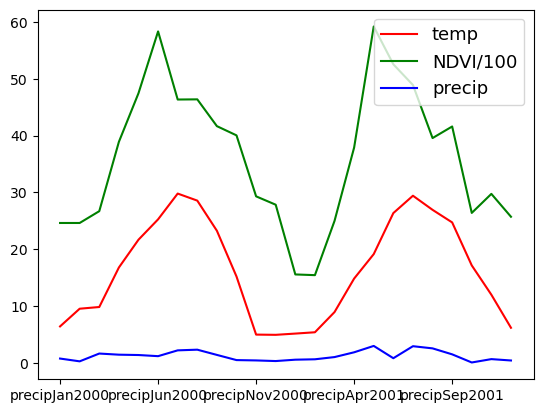

In [179]:
temp_cols = [i for i in time_series_gdf.columns if 'temp' in i]
time_series_gdf[temp_cols].iloc[0][0:24].plot(color='red',label= "temp")

temp_cols = [i for i in time_series_gdf.columns if 'NDVI' in i]
time_series_gdf[temp_cols].iloc[0][0:24].divide(100).plot(label='NDVI/100',color='green')

temp_cols = [i for i in time_series_gdf.columns if 'precip' in i]
time_series_gdf[temp_cols].iloc[0][0:24].plot(label='precip',color='blue')
plt.legend(loc='upper right')



### Read in LAI Data (monthly)

In [180]:
# lai_id = r'1Q4G3-ypzEfthwJzprHD1tT5irA2AXL0h'

# print(time_series_gdf)
lai_band_names = ['Band 1: Feb00', 'Band 2: Mar00', 'Band 3: Apr00', 'Band 4: May00', 'Band 5: Jun00', 'Band 6: Jul00', 'Band 7: Aug00', 'Band 8: Sep00', 'Band 9: Oct00', 'Band 10: Nov00', 'Band 11: Dec00', 'Band 12: Jan01', 'Band 13: Feb01', 'Band 14: Mar01', 'Band 15: Apr01', 'Band 16: May01', 'Band 17: Jun01', 'Band 18: Jul01', 'Band 19: Aug01', 'Band 20: Sep01', 'Band 21: Oct01', 'Band 22: Nov01', 'Band 23: Dec01', 'Band 24: Jan02', 'Band 25: Feb02', 'Band 26: Mar02', 'Band 27: Apr02', 'Band 28: May02', 'Band 29: Jun02', 'Band 30: Jul02', 'Band 31: Aug02', 'Band 32: Sep02', 'Band 33: Oct02', 'Band 34: Nov02', 'Band 35: Dec02', 'Band 36: Jan03', 'Band 37: Feb03', 'Band 38: Mar03', 'Band 39: Apr03', 'Band 40: May03', 'Band 41: Jun03', 'Band 42: Jul03', 'Band 43: Aug03', 'Band 44: Sep03', 'Band 45: Oct03', 'Band 46: Nov03', 'Band 47: Dec03', 'Band 48: Jan04', 'Band 49: Feb04', 'Band 50: Mar04', 'Band 51: Apr04', 'Band 52: May04', 'Band 53: Jun04', 'Band 54: Jul04', 'Band 55: Aug04', 'Band 56: Sep04', 'Band 57: Oct04', 'Band 58: Nov04', 'Band 59: Dec04', 'Band 60: Jan05', 'Band 61: Feb05', 'Band 62: Mar05', 'Band 63: Apr05', 'Band 64: May05', 'Band 65: Jun05', 'Band 66: Jul05', 'Band 67: Aug05', 'Band 68: Sep05', 'Band 69: Oct05', 'Band 70: Nov05', 'Band 71: Dec05', 'Band 72: Jan06', 'Band 73: Feb06', 'Band 74: Mar06', 'Band 75: Apr06', 'Band 76: May06', 'Band 77: Jun06', 'Band 78: Jul06', 'Band 79: Aug06', 'Band 80: Sep06', 'Band 81: Oct06', 'Band 82: Nov06', 'Band 83: Dec06', 'Band 84: Jan07', 'Band 85: Feb07', 'Band 86: Mar07', 'Band 87: Apr07', 'Band 88: May07', 'Band 89: Jun07', 'Band 90: Jul07', 'Band 91: Aug07', 'Band 92: Sep07', 'Band 93: Oct07', 'Band 94: Nov07', 'Band 95: Dec07', 'Band 96: Jan08', 'Band 97: Feb08', 'Band 98: Mar08', 'Band 99: Apr08', 'Band 100: May08', 'Band 101: Jun08', 'Band 102: Jul08', 'Band 103: Aug08', 'Band 104: Sep08', 'Band 105: Oct08', 'Band 106: Nov08', 'Band 107: Dec08', 'Band 108: Jan09', 'Band 109: Feb09', 'Band 110: Mar09', 'Band 111: Apr09', 'Band 112: May09', 'Band 113: Jun09', 'Band 114: Jul09', 'Band 115: Aug09', 'Band 116: Sep09', 'Band 117: Oct09', 'Band 118: Nov09', 'Band 119: Dec09', 'Band 120: Jan10', 'Band 121: Feb10', 'Band 122: Mar10', 'Band 123: Apr10', 'Band 124: May10', 'Band 125: Jun10', 'Band 126: Jul10', 'Band 127: Aug10', 'Band 128: Sep10', 'Band 129: Oct10', 'Band 130: Nov10', 'Band 131: Dec10', 'Band 132: Jan11', 'Band 133: Feb11', 'Band 134: Mar11', 'Band 135: Apr11', 'Band 136: May11', 'Band 137: Jun11', 'Band 138: Jul11', 'Band 139: Aug11', 'Band 140: Sep11', 'Band 141: Oct11', 'Band 142: Nov11', 'Band 143: Dec11', 'Band 144: Jan12', 'Band 145: Feb12', 'Band 146: Mar12', 'Band 147: Apr12', 'Band 148: May12', 'Band 149: Jun12', 'Band 150: Jul12', 'Band 151: Aug12', 'Band 152: Sep12', 'Band 153: Oct12', 'Band 154: Nov12', 'Band 155: Dec12', 'Band 156: Jan13', 'Band 157: Feb13', 'Band 158: Mar13', 'Band 159: Apr13', 'Band 160: May13', 'Band 161: Jun13', 'Band 162: Jul13', 'Band 163: Aug13', 'Band 164: Sep13', 'Band 165: Oct13', 'Band 166: Nov13', 'Band 167: Dec13', 'Band 168: Jan14', 'Band 169: Feb14', 'Band 170: Mar14', 'Band 171: Apr14', 'Band 172: May14', 'Band 173: Jun14', 'Band 174: Jul14', 'Band 175: Aug14', 'Band 176: Sep14', 'Band 177: Oct14', 'Band 178: Nov14', 'Band 179: Dec14', 'Band 180: Jan15', 'Band 181: Feb15', 'Band 182: Mar15', 'Band 183: Apr15', 'Band 184: May15', 'Band 185: Jun15', 'Band 186: Jul15', 'Band 187: Aug15', 'Band 188: Sep15', 'Band 189: Oct15', 'Band 190: Nov15', 'Band 191: Dec15', 'Band 192: Jan16', 'Band 193: Feb16', 'Band 194: Mar16', 'Band 195: Apr16', 'Band 196: May16', 'Band 197: Jun16', 'Band 198: Jul16', 'Band 199: Aug16', 'Band 200: Sep16', 'Band 201: Oct16', 'Band 202: Nov16', 'Band 203: Dec16', 'Band 204: Jan17', 'Band 205: Feb17', 'Band 206: Mar17', 'Band 207: Apr17', 'Band 208: May17', 'Band 209: Jun17', 'Band 210: Jul17', 'Band 211: Aug17', 'Band 212: Sep17', 'Band 213: Oct17', 'Band 214: Nov17', 'Band 215: Dec17', 'Band 216: Jan18', 'Band 217: Feb18', 'Band 218: Mar18', 'Band 219: Apr18', 'Band 220: May18', 'Band 221: Jun18', 'Band 222: Jul18', 'Band 223: Aug18', 'Band 224: Sep18', 'Band 225: Oct18', 'Band 226: Nov18', 'Band 227: Dec18', 'Band 228: Jan19', 'Band 229: Feb19', 'Band 230: Mar19', 'Band 231: Apr19', 'Band 232: May19', 'Band 233: Jun19', 'Band 234: Jul19', 'Band 235: Aug19', 'Band 236: Sep19', 'Band 237: Oct19', 'Band 238: Nov19', 'Band 239: Dec19', 'Band 240: Jan20', 'Band 241: Feb20', 'Band 242: Mar20', 'Band 243: Apr20', 'Band 244: May20', 'Band 245: Jun20', 'Band 246: Jul20', 'Band 247: Aug20', 'Band 248: Sep20', 'Band 249: Oct20', 'Band 250: Nov20', 'Band 251: Dec20', 'Band 252: Jan21', 'Band 253: Feb21', 'Band 254: Mar21', 'Band 255: Apr21', 'Band 256: May21', 'Band 257: Jun21', 'Band 258: Jul21', 'Band 259: Aug21', 'Band 260: Sep21', 'Band 261: Oct21', 'Band 262: Nov21', 'Band 263: Dec21']
target_lai_band_names = ['LAI'+d[-5:] for d in lai_band_names]

# for i in range(1,22):
#   if len(str(i)) ==1:
#     lai_band_names.append('Band 00'+ str(i)+": ")
#   elif len(str(i)) ==2:
#     lai_band_names.append('Band 0'+ str(i)+": ")

time_series_gdf_lai = turn_raster_output_to_gdf(lai_fp, points_shp, band_names_stack=lai_band_names, prefire_months = 120)

# rename bands
renameLAI_dict = {i:j for i,j in zip(lai_band_names, target_lai_band_names)}
time_series_gdf_lai = time_series_gdf_lai.rename(columns=renameLAI_dict)

time_series_gdf_lai.head()

,LAIFeb00,LAIMar00,LAIApr00,LAIMay00,LAIJun00,LAIJul00,LAIAug00,LAISep00,LAIOct00,LAINov00,...,LAIApr21,LAIMay21,LAIJun21,LAIJul21,LAIAug21,LAISep21,LAIOct21,LAINov21,LAIDec21,geometry
0,1,2,4,10,9,8,7,6,4,3,...,3,7,12,12,8,5,4,3,3,POINT (-105.25908 39.75820)
1,5,5,10,13,18,24,21,18,11,9,...,6,8,17,20,16,12,8,6,6,POINT (-105.65164 38.23708)
2,4,4,7,20,23,20,17,15,13,9,...,1,4,8,13,13,10,5,5,2,POINT (-105.69269 40.36949)
3,3,3,6,11,16,16,12,9,5,3,...,2,5,13,16,16,9,4,2,1,POINT (-104.36315 37.01745)
4,4,4,7,8,10,9,8,8,5,4,...,2,6,12,14,10,6,3,3,3,POINT (-105.31692 40.60589)


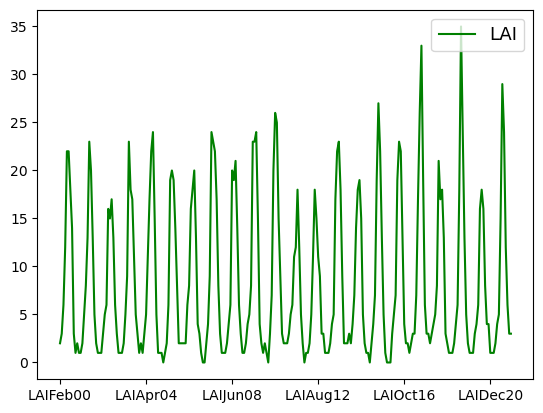

In [181]:

temp_cols = [i for i in time_series_gdf_lai.columns if 'LAI' in i]
time_series_gdf_lai[temp_cols].iloc[9].plot(label='LAI',color='green')
plt.legend(loc='upper right')

### Read in VCF Data (annual) - to add

In [182]:
# vcf_nonveg_id = r'1X3eNUgHxJJ-O8y2L8Xvg_4h48IzLuPGJ'
# vcf_tree_id = r'1CLAQxvZ0t8loDKJZPXsSgEq1EQ-b07Rz'
# vcf_nontree_id = r'1AG3GsdeayN6mTLL7BWY53bEen1eok_oJ'

vcf_tree_bandnames = ['PctTree00','PctTree01','PctTree02','PctTree03','PctTree04','PctTree05','PctTree06','PctTree07','PctTree08','PctTree09','PctTree10','PctTree11','PctTree12','PctTree13','PctTree14','PctTree15','PctTree16','PctTree17','PctTree18','PctTree19','PctTree20']
time_series_gdf_vcfTree = turn_raster_output_to_gdf(vcf_tree_fp, points_shp, vcf_tree_bandnames, prefire_months = 120)
time_series_gdf_vcfTree.head()

,PctTree00,PctTree01,PctTree02,PctTree03,PctTree04,PctTree05,PctTree06,PctTree07,PctTree08,PctTree09,...,PctTree12,PctTree13,PctTree14,PctTree15,PctTree16,PctTree17,PctTree18,PctTree19,PctTree20,geometry
0,3,6,4,5,5,4,4,4,6,6,...,5,5,9,5,3,3,15,7,4,POINT (-105.25908 39.75820)
1,35,23,38,29,35,37,34,22,29,28,...,24,28,21,25,17,20,16,16,17,POINT (-105.65164 38.23708)
2,52,48,54,61,53,52,49,55,54,50,...,55,25,24,27,24,23,19,24,28,POINT (-105.69269 40.36949)
3,8,5,8,5,8,12,11,13,5,10,...,12,9,11,9,4,5,13,4,9,POINT (-104.36315 37.01745)
4,12,15,5,15,9,6,11,14,8,11,...,10,20,11,13,5,14,3,11,7,POINT (-105.31692 40.60589)


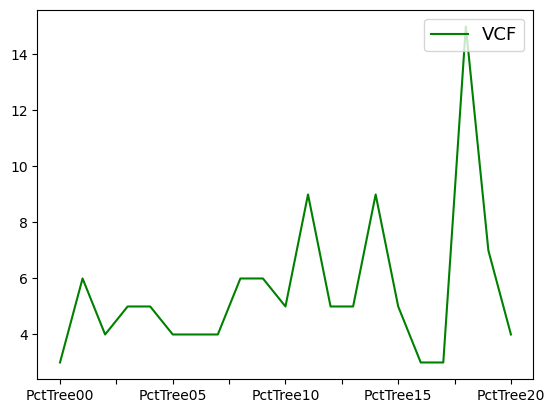

In [183]:

temp_cols = [i for i in time_series_gdf_vcfTree.columns if 'Tree' in i]
time_series_gdf_vcfTree[temp_cols].iloc[0].plot(label='VCF',color='green')
plt.legend(loc='upper right')


#### Preprocess VCF Tree Cover Pct DataFrame

In [184]:
#preprocess VCf Tree cover data

# Assuming you have a Pandas GeoDataFrame called 'gdf'
# Replace 'gdf' with the name of your GeoDataFrame

# Dictionary to map month numbers to their corresponding names
month_mapping = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}

# List to store the columns to be deleted
columns_to_delete = []

# Loop through each column in the GeoDataFrame
for column in time_series_gdf_vcfTree.columns:
    # Check if the column name starts with "PctTree" (assuming all such columns are to be duplicated)
    if column.startswith("PctTree"):
        # Get the year from the column name (assuming it is the last two characters of the column name)
        year = column[-2:]

        # Loop through each month (1 to 12) and create a new column for each
        for month in range(1, 13):
            # Create the new column name for the current year
            new_column_name = column.replace("PctTree", "Tree" + month_mapping[month])

            # Copy the data from the original column to the new column for the current year
            time_series_gdf_vcfTree[new_column_name] = time_series_gdf_vcfTree[column]

        # If the current year is 2020, copy the data to the new column for the next year (2021)
        if year == "20":

            for month in range(1, 13):
              # Create the new column name for the current year
              new_column_name = column.replace("PctTree20", "Tree" + month_mapping[month]+"21")

              # Copy the data from the original column to the new column for the current year
              time_series_gdf_vcfTree[new_column_name] = time_series_gdf_vcfTree[column]

        # Add the original column to the list of columns to delete
        columns_to_delete.append(column)

# Delete the original columns
time_series_gdf_vcfTree.drop(columns=columns_to_delete, inplace=True)

# Now the GeoDataFrame 'gdf' will have the original columns duplicated 12 times with the new column names
# "TreeJan00", "TreeFeb00", etc., and the original columns that started with "PctTree" will be deleted.
# Additionally, the 2020 data will be copied into 12 additional columns for 2021.


/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/geodataframe.py:1322: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/geodataframe.py:1322: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/geodataframe.py:1322: Performan

### Read in fire boundary geojson

In [185]:
# Read in the fire boundaries, converting the date into a readable format
# fire_bounds = gpd.read_file("1oJCQEuNJxVx-ZHgP8wB9zroj-eOTqcd2", "ForestFires_MLFinal.geojson").to_crs(time_series_gdf.crs) #randomly stopped working
# fire_bounds = gpd.read_file("1VAJH-CWXTZptd42pdqAFRIbK7L2AEp09", "ForestFires_MLFinal.geojson").to_crs(time_series_gdf.crs) #recreated file as _copy2
# fireboundID = '1VAJH-CWXTZptd42pdqAFRIbK7L2AEp09'# old: "1BUH0uAxoGGfGNd8LtbeeSMUYXNS_foq3"
fire_bounds = gpd.read_file(fire_bounds_fp)#.to_crs(time_series_gdf.crs)#fireboundID, "ForestFires_MLFinal.geojson").to_crs(time_series_gdf.crs)
print("CRS is equal:",fire_bounds.crs==time_series_gdf.crs)
fire_bounds['Ig_Date'] = fire_bounds.Ig_Date.apply(convert_epoch_milli_to_datetime)
fire_bounds_dates = fire_bounds[['Ig_Date','Event_ID', 'geometry']]

#check whether event ID is unique
print(len(fire_bounds_dates['Event_ID']) == len(set(fire_bounds_dates['Event_ID'])))


CRS is equal: True
True


In [186]:
print(fire_bounds.crs)
print(time_series_gdf.crs)
print(time_series_gdf_lai.crs)
print(time_series_gdf_vcfTree.crs)

epsg:4326
epsg:4326
epsg:4326
epsg:4326


### Add in the dates from the fire boundaries to the point data

In [187]:
# Add in the dates from the fire boundaries to the point data
time_series_fire_date = gpd.sjoin(time_series_gdf, fire_bounds_dates, how='inner')
#rename column to prepare for next sjoin
time_series_fire_date = time_series_fire_date.rename(columns={'index_right': 'index_right1'})
#join lai data frame with dynamic stack (ndiv, precip, temp) data frame
time_series_fire_date = gpd.sjoin(time_series_fire_date, time_series_gdf_lai)
time_series_fire_date = time_series_fire_date.rename(columns={'index_right': 'index_right2'})

time_series_fire_date = gpd.sjoin(time_series_fire_date, time_series_gdf_vcfTree)

time_series_fire_date = time_series_fire_date[~time_series_fire_date.index.duplicated(keep='first')]
time_series_fire_date = time_series_fire_date.drop(['index_right'], axis=1)
print(time_series_fire_date['Ig_Date'][0:2])
time_series_fire_date.head()

#everythign is confirmed ok here...
# save_this = time_series_fire_date[['Event_ID','geometry']].copy()
# save_this.to_file("time_series_fire_date_og.shp",geometry='geometry')

0     2011-03-20 01:00:00
420   2011-03-20 01:00:00
Name: Ig_Date, dtype: datetime64[ns]


,tempJan2000,precipJan2000,NDVIJan2000,tempFeb2000,precipFeb2000,NDVIFeb2000,tempMar2000,precipMar2000,NDVIMar2000,tempApr2000,...,TreeMar21,TreeApr21,TreeMay21,TreeJun21,TreeJul21,TreeAug21,TreeSep21,TreeOct21,TreeNov21,TreeDec21
0,6.46,0.81,2464.0,9.57,0.32,2464.0,9.87,1.69,2671.5,16.81,...,4,4,4,4,4,4,4,4,4,4
420,6.99,0.80,2606.0,9.95,0.32,2606.0,10.26,1.65,3074.0,17.30,...,10,10,10,10,10,10,10,10,10,10
457,5.80,0.82,2900.0,8.97,0.32,2900.0,9.29,1.73,2885.0,16.14,...,13,13,13,13,13,13,13,13,13,13
573,5.78,0.81,3247.0,8.94,0.32,3247.0,9.28,1.73,2985.0,16.12,...,28,28,28,28,28,28,28,28,28,28
665,7.36,0.80,2086.0,10.30,0.32,2086.0,10.59,1.62,2386.5,17.68,...,14,14,14,14,14,14,14,14,14,14


### Split gdf into variable groups for viz.

In [188]:
# Split the dataframe into the variables currently stored in it
#NOTE: error occurs when I set precip etc based off of time_series_fire_date rather than time_series_gdf...
# precip = time_series_gdf[time_series_gdf.columns[time_series_gdf.columns.str.startswith('precip')]]
# print(time_series_gdf.head())
# precip = precip.join(time_series_fire_date['Ig_Date'], on='Ig_Date').join(time_series_fire_date['Event_ID'])

# temp = time_series_gdf[time_series_gdf.columns[time_series_gdf.columns.str.startswith('temp')]].join(time_series_fire_date['Ig_Date'])
# ndvi = time_series_gdf[time_series_gdf.columns[time_series_gdf.columns.str.startswith('NDVI')]].join(time_series_fire_date['Ig_Date'])
selectThese =  [i.startswith('precip') or 'Ig_Date' in i or 'Event_ID' in i for i in time_series_fire_date.columns] #bool list
precip = time_series_fire_date[time_series_fire_date.columns[selectThese]]

selectThese =  [i.startswith('temp') or 'Ig_Date' in i  for i in time_series_fire_date.columns] #bool list
temp = time_series_fire_date[time_series_fire_date.columns[selectThese]]

selectThese =  [i.startswith('NDVI') or 'Ig_Date' in i  for i in time_series_fire_date.columns] #bool list
ndvi = time_series_fire_date[time_series_fire_date.columns[selectThese]]

selectThese =  [i.startswith('LAI') or 'Ig_Date' in i for i in time_series_fire_date.columns] #bool list
lai = time_series_fire_date[time_series_fire_date.columns[selectThese]]


selectThese =  [i.startswith('Tree') or 'Ig_Date' in i for i in time_series_fire_date.columns] #bool list
vcf_tree = time_series_fire_date[time_series_fire_date.columns[selectThese]]
# precip = time_series_fire_date[time_series_fire_date.columns[time_series_fire_date.columns.str.startswith('precip')]].join(time_series_fire_date['Ig_Date']).join(time_series_fire_date['Event_ID'])
# temp = time_series_fire_date[time_series_fire_date.columns[time_series_fire_date.columns.str.startswith('temp')]].join(time_series_fire_date['Ig_Date'])
# ndvi = time_series_fire_date[time_series_fire_date.columns[time_series_fire_date.columns.str.startswith('NDVI')]].join(time_series_fire_date['Ig_Date'])

# lai = time_series_fire_date[time_series_fire_date.columns[time_series_fire_date.columns.str.startswith('LAI')]].join(time_series_fire_date['Ig_Date'])
# lai = time_series_gdf_lai[time_series_gdf_lai.columns[time_series_gdf_lai.columns.str.startswith('LAI')]]#.join(time_series_fire_date['Ig_Date'])

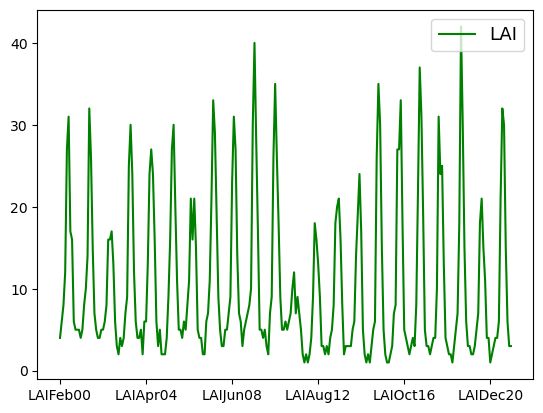

In [189]:

temp_cols = [i for i in lai.columns if 'LAI' in i]
lai[temp_cols].iloc[96].plot(label='LAI',color='green')
plt.legend(loc='upper right')

In [190]:
# Put the regular data frames into geodataframes so it can be visually spot checked
precip_gdf = gpd.GeoDataFrame(precip, geometry=time_series_fire_date.geometry, crs=time_series_fire_date.crs)
temp_gdf = gpd.GeoDataFrame(temp, geometry=time_series_fire_date.geometry, crs=time_series_fire_date.crs)
ndvi_gdf = gpd.GeoDataFrame(ndvi, geometry=time_series_fire_date.geometry, crs=time_series_fire_date.crs)
lai_gdf = gpd.GeoDataFrame(lai, geometry=time_series_fire_date.geometry, crs=time_series_fire_date.crs)
vcf_tree_gdf = gpd.GeoDataFrame(vcf_tree, geometry=time_series_fire_date.geometry, crs=time_series_fire_date.crs)

# id_gdf = gpd.GeoDataFrame(ndvi, geometry=time_series_gdf.geometry, crs=time_series_gdf.crs)

# #good here
# save_this = precip_gdf[['Event_ID','geometry']].copy()
# save_this.to_file("1precip_gdf.shp",geometry='geometry')

# save_this = lai_gdf[['Event_ID','geometry']].copy()
# save_this.to_file("2lai_gdf.shp",geometry='geometry')

# store_copy_of_geom = lai_gdf.geometry

### Viz Data

/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/clairesim

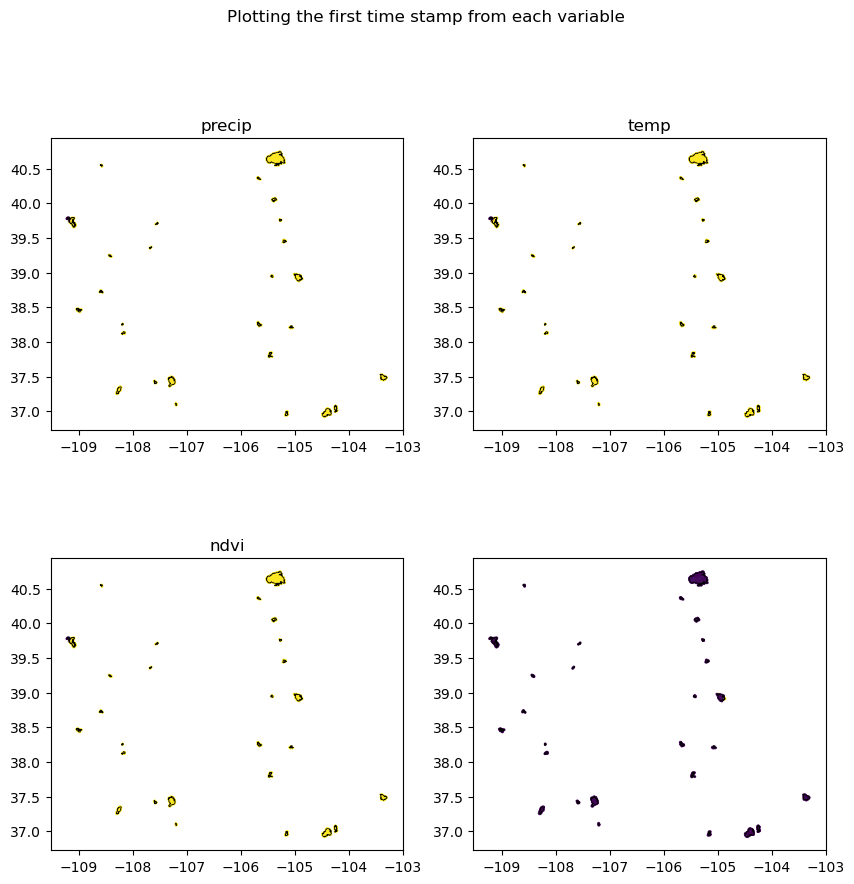

In [191]:
# Plot the data types and their spatial extents
fig, axes = plt.subplots(2, 2, figsize=(10,10))
ax1, ax2, ax3, ax4 = axes[0][0], axes[0][1], axes[1][0], axes[1][1]
ax1.set_title("precip")
ax2.set_title("temp")
ax3.set_title("ndvi")
precip_gdf.plot(column="precipJan2000", ax=ax1, markersize=1)
temp_gdf.plot(column="tempJan2000", ax=ax2, markersize=1)
ndvi_gdf.plot(column="NDVIJan2000", ax=ax3, markersize=1)
lai_gdf.plot(column="LAIFeb01", ax=ax4, markersize=1)
# id_gdf.plot(column='Post_ID', ax=ax4, markersize=1)
for ax in axes:
  for a in ax:
    fire_bounds.boundary.plot(ax=a, color='black', linewidth=.5)
fig.suptitle("Plotting the first time stamp from each variable")
plt.show()

### Split data into model input  vs. output

- input: pre-fire NDVI, precip, temp

- output: post-fire NDVI

*NOTE*: will want to change the breakpoint date b/w input and output data in order for the model to see the first year (ish?) of NDVI change after fire -- how will this affect model?

In [192]:
# Take the datasets created, loop through them, parse the date from the column
# name, and then create a pandas time series for just that variable at each point

#how many months after fire do we want to split model input vs. output?
postfire_mo = 12
prefire_mo = 120 + postfire_mo  #120 = 12 mo/year * 10 years

#will want to change the fire date break point to be later..
precip_series = []
temp_series = []
ndvi_before_series = []
ndvi_after_series = []
lai_before_series = []
lai_after_series = []
vcf_tree_before_series = []
vcf_tree_after_series = []
event_series = []

# Parsing the precip data
for i, row in precip_gdf.iterrows():
    #i is the row index; row is the row value container
    # print(i)
    # print('\n\n\n',row)
    # break
    # Get the dates from the column name
    dates = [parser.parse(j[6:]) for j in row.index[:-3]]
    dates = [d.replace(day=calendar.monthrange(d.year, d.month)[1], hour=23, minute = 59) for d in dates] #format: NDVIFeb2000 - wer're selecting Feb2000

    # Get the fire date
        #increment fire date by 1 month

    fire_date = row.Ig_Date #+ relativedelta(months=+1)
    split_date = fire_date + relativedelta(months = postfire_mo)

    # Get the date of 10 years before the fire (or split date)
    #increment fire date by n months
    fire_date_10_before = split_date - relativedelta(months = prefire_mo )#+ postfire_mo)

    # Put the data into a pandas time series, clip it to the temporal extent, and append to a list
    precip_series.append(pd.Series(row.values[:-3], index=dates, name=i)[fire_date_10_before:split_date].tolist())
    event_series.append(row.values[-2]) #event ID value


# Parsing the temperature data
for i, row in temp_gdf.iterrows():
    # Get the dates from the column name
    dates = [parser.parse(j[4:]) for j in row.index[:-2]]
    dates = [d.replace(day=calendar.monthrange(d.year, d.month)[1], hour=23, minute = 59) for d in dates] #format: NDVIFeb2000 - wer're selecting Feb2000

    # Get the fire date
    fire_date = row.Ig_Date #+ relativedelta(months=+1)
    split_date = fire_date + relativedelta(months = postfire_mo)
    # Get the date of 10 years before the fire
    fire_date_10_before = split_date - relativedelta(months = prefire_mo )#+ postfire_mo)
    #increment fire date by 1 month
    # fire_date = fire_date + relativedelta(months=+1)
    # Put the data into a pandas time series, clip it to the temporal extent, and append to a list
    temp_series.append(pd.Series(row.values[:-2], index=dates, name= i)[fire_date_10_before:split_date].tolist())

# Parsing the NDVI data
for i, row in ndvi_gdf.iterrows():
    # Get the dates from the column name
    dates = [parser.parse(j[4:]) for j in row.index[:-2]] #format: NDVIFeb2000 - wer're selecting Feb2000
    dates = [d.replace(day=calendar.monthrange(d.year, d.month)[1], hour=23, minute = 59) for d in dates] #format: NDVIFeb2000 - wer're selecting Feb2000

    # Get the fire date
    fire_date = row.Ig_Date #+ relativedelta(months=+1)
    split_date = fire_date + relativedelta(months = postfire_mo)
    # Get the date of 10 years before the fire
    fire_date_10_before = split_date - relativedelta(months = prefire_mo )#+ postfire_mo)
    # Get the date of 9 years after the fire (not 10 due to a few fires that this goes to far into the future for)
    fire_date_10_after = split_date + relativedelta(months = 110-postfire_mo)
    # Adding both datasets to seperate lists
    ndvi_before_series.append(pd.Series(row.values[:-2], index=dates, name= i)[fire_date_10_before:split_date].tolist()) #exclusive of fire_date?
    ndvi_after_series.append(pd.Series(row.values[:-2], index=dates, name= i)[split_date:fire_date_10_after].tolist()) #inclusive of fire_date



In [193]:
#parse LAI data
geom_series =[ ]

for i, row in lai_gdf.iterrows():
  
    # Get the dates from the column name
    dates = [parser.parse(j[3:6]+'20'+j[-2:]) for j in row.index[1:-1]] #only using row index [1:-1] to exclude first and last col, which are ig_date and geometry,respectively
    dates = [d.replace(day=calendar.monthrange(d.year, d.month)[1], hour=23, minute = 59) for d in dates] #format: NDVIFeb2000 - wer're selecting Feb2000

    # Get the fire date
    fire_date = row.Ig_Date #+ relativedelta(months=+1)
    split_date = fire_date + relativedelta(months = postfire_mo)
    # Get the date of 10 years before the fire
    fire_date_10_before = split_date - relativedelta(months = prefire_mo )#+ postfire_mo)
    # Get the date of 9 years after the fire (not 10 due to a few fires that this goes to far into the future for)
    fire_date_10_after = split_date + relativedelta(months = 110-postfire_mo)
    # Adding both datasets to seperate lists
    lai_before_series.append(pd.Series(row.values[1:-1], index=dates, name= i)[fire_date_10_before:split_date].tolist()) #exclusive of fire_date?
    lai_after_series.append(pd.Series(row.values[1:-1], index=dates, name= i)[split_date:fire_date_10_after].tolist()) #inclusive of fire_date
    geom_series.append(row.geometry)




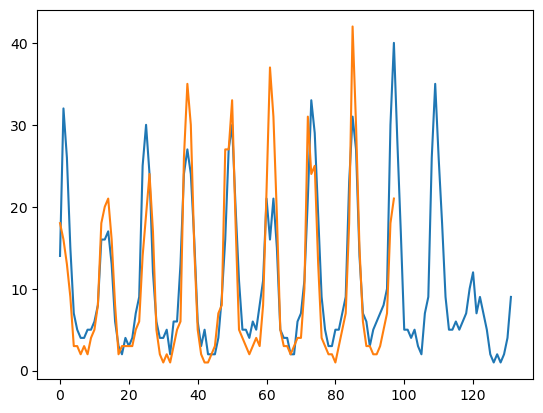

In [194]:
plt.plot(lai_before_series[96])
plt.plot(lai_after_series[96])


In [195]:
#parse VCF Tree data

for i, row in vcf_tree_gdf.iterrows():
    # Get the dates from the column name
    dates = [parser.parse(j[4:7]+'20'+j[-2:]) for j in row.index[1:-1]] #only using row index [1:-1] to exclude first and last col, which are ig_date and geometry,respectively
    dates = [d.replace(day=calendar.monthrange(d.year, d.month)[1], hour=23, minute = 59) for d in dates] #format: NDVIFeb2000 - wer're selecting Feb2000

    # print(row.index[1][4:7]+'20'+row.index[1][-2:])
    # break
    # Get the fire date
    fire_date = row.Ig_Date #+ relativedelta(months=+1)
    split_date = fire_date + relativedelta(months = postfire_mo)
    # Get the date of 10 years before the fire
    fire_date_10_before = split_date - relativedelta(months = prefire_mo )#+ postfire_mo)
    # Get the date of 9 years after the fire (not 10 due to a few fires that this goes to far into the future for)
    fire_date_10_after = split_date + relativedelta(months = 110-postfire_mo)
    # Adding both datasets to seperate lists
    vcf_tree_before_series.append(pd.Series(row.values[1:-1], index=dates, name= i)[fire_date_10_before:split_date].tolist()) #exclusive of fire_date?
    vcf_tree_after_series.append(pd.Series(row.values[1:-1], index=dates, name= i)[split_date:fire_date_10_after].tolist()) #inclusive of fire_date




In [196]:

# reorganize = pd.DataFrame(list(zip(*[ lai_before_series,event_series])),
#                           columns = ['lai','Event_ID'])
# print(reorganize.head())
# reorganize_gdf = gpd.GeoDataFrame(reorganize,
#                                   geometry = geom_series,
#                                   crs = time_series_fire_date.crs)


# time_series_fire_date.head()
# #this is fine too
# save_this = reorganize_gdf[['Event_ID','geometry']].copy()
# save_this.to_file("next_test56.shp",geometry='geometry')

In [197]:

#check that theyre all the same length
print(len(ndvi_after_series), len(ndvi_after_series[1]))#[1].shape)
print(len(ndvi_before_series), len(ndvi_before_series[1]))#[1].shape)
print(len(lai_after_series), len(lai_after_series[1]))#[1].shape)


for i in range(len(ndvi_before_series)):
  if len(precip_series[i]) !=prefire_mo or len(temp_series[i]) !=prefire_mo or len(ndvi_before_series[i])!=prefire_mo or len(lai_before_series[i])!= prefire_mo or len(vcf_tree_before_series[i]) !=prefire_mo:
    print(i)
    raise
  if np.isnan(precip_series[i][-1]) and not np.isnan(precip_series[i][1]):
    print("NAN", precip_series[i][-1])
    raise

for i in range(len(ndvi_after_series)):
  if len(ndvi_after_series[i])!=110-postfire_mo or len(lai_after_series[i])!=110-postfire_mo or (np.isnan(ndvi_after_series[i][-1]) and not np.isnan(ndvi_after_series[i][1])):
    print(i, len(ndvi_after_series[i]), ndvi_after_series[i][-1])
    raise


1015 98
1015 132
1015 98


### Re-create gdf where columns contain listed timeseries

#### THIS IS WHERE ERROR is found (by exporting shp)

In [198]:
# Reingests all of the data into a geodataframe that has the time series for
#each variable stored in each cell, and the ndvi split up before and after fire date

Ig_Series = time_series_fire_date['Ig_Date']
Id_Series = time_series_fire_date['Event_ID']#event_series (also works) #time_series_fire_date['Event_ID'] #event series is list of fires for each row in df (so repeating fire ids)
#Note on Event_ID [from GEE]: Unique identifier for each event (21 characters). Calculated from source data (ICS209, FedFire, etc.) ;
#   each time an event is created or updated using the state, lat/long coordinates (ig_lat, ig_long). Note that for longitudes less than 100° a leading zero is added to maintain 21 characters.

# Id_Series = time_series_fire_date['FireIgID']

#ERROR IS HERE (dif vars were not in correct order - can check by viz the output shp and see how labels of fire event IDs are not consistent throughout fires)
# this error occurs when i set
#Error was due to having the geometry in different order than other variables
reorganize = pd.DataFrame(list(zip(*[precip_series, temp_series, ndvi_before_series, lai_before_series, vcf_tree_before_series,
                                      ndvi_after_series, lai_after_series,vcf_tree_after_series,
                                      Ig_Series, Id_Series, time_series_fire_date.geometry])),
                          columns = ['precip', 'temp', 'ndvi_before', 'lai_before', 'vcf_tree_before',
                                     'ndvi_after', 'lai_after', 'vcf_tree_after',
                                     'Ig_Date','Event_ID', 'geom'])
# print(reorganize.head())
reorganize_gdf = gpd.GeoDataFrame(reorganize,
                                  geometry = 'geom',#time_series_fire_date.geometry,
                                  crs = time_series_fire_date.crs)


# time_series_fire_date.head()
# compare(reorganize_gdf.geometry, time_series_fire_date.geometry)
#this fails
# save_this = reorganize_gdf[['Event_ID','geom']].copy()
# save_this.to_file("next_test57.shp",geometry='geometry')

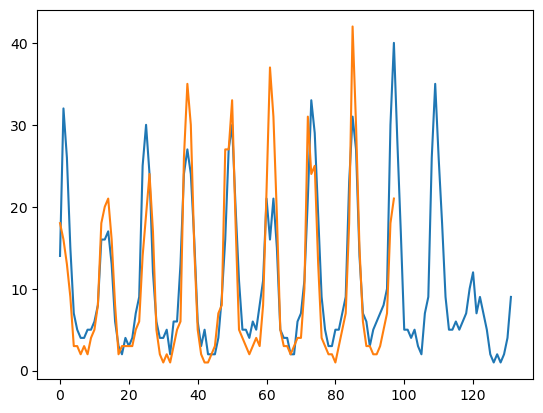

In [199]:

temp_cols = [i for i in reorganize_gdf.columns if 'lai_b' in i]
sdfg=reorganize_gdf[temp_cols].iloc[96].tolist()
plt.plot(sdfg[0])

temp_cols = [i for i in reorganize_gdf.columns if 'lai_a' in i]
sdfg=reorganize_gdf[temp_cols].iloc[96].tolist()
plt.plot(sdfg[0])
#.plot(label='LAI',color='green')
# plt.legend(loc='upper right')#

### Read static-var rasters

In [200]:
time_series_fire_date.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [201]:
# Loop through all static rasters and extract the point data needed for them
# There are 4 rasters that cover different spatial extents of Colorado. The full state was too big to export as one raster
static_rasters =[static_fp1, static_fp2, static_fp3, static_fp4]
#NOTE******** this static stack contains the wrong version of burn severity 
static_gdfs = []
for raster in static_rasters:
    print(raster, 'is processing..')
    print(os.path.exists(raster))
    static_gdfs.append(turn_raster_output_to_gdf_STATIC(raster, time_series_fire_date, ['slope', 'chili', 'elevation', 'aspect', 'severity', 'mtpi'],prefire_mo))
    


/Users/clairesimpson/Desktop/CU/LSTM_Project/MLFinalProject/Data/MLFinal_RasterStack_Static-0000000000-0000000000_4326.tif is processing..
True


There are 316 points located in this tile!!
/Users/clairesimpson/Desktop/CU/LSTM_Project/MLFinalProject/Data/MLFinal_RasterStack_Static-0000000000-0000013568_4326.tif is processing..
True
There are 688 points located in this tile!!
/Users/clairesimpson/Desktop/CU/LSTM_Project/MLFinalProject/Data/MLFinal_RasterStack_Static-0000013568-0000000000_4326.tif is processing..
True
There are 8 points located in this tile!!
/Users/clairesimpson/Desktop/CU/LSTM_Project/MLFinalProject/Data/MLFinal_RasterStack_Static-0000013568-0000013568_4326.tif is processing..
True
There are 155 points located in this tile!!


### Add burn severity seperately from static rasters

In [202]:
# # reproject all burn severity rasters (do this once)

# burnsev_rasters = [os.path.join(burn_main_dir,tif) for tif in os.listdir(burn_main_dir) if tif.endswith('.tif') and 'prj' not in tif]

# for raster in burnsev_rasters:
#     print(raster, 'is processing..')
#     print(os.path.exists(raster))
#     if not os.path.exists(raster.replace('.tif','_ptj.tif')):
#         reproject_raster(raster,time_series_fire_date.crs)


In [203]:
#explicitly add in burn severity bc this layer has a resolution-based issue and thus leads to no data

# Loop through all static rasters and extract the point data needed for them
# There are 4 rasters that cover different spatial extents of Colorado. The full state was too big to export as one raster
burnsev_rasters_prj = [os.path.join(burn_main_dir,tif) for tif in os.listdir(burn_main_dir) if tif.endswith('.tif')]
# print(burnsev_rasters_prj)
burnsev_rasters_withPoints = [] #store which rasters actually do have points in them (for burn sev this should be all of them)
burnsev_gdfs = []

for raster in burnsev_rasters_prj:
    print(raster, 'is processing..')
    to_add = turn_raster_output_to_gdf_STATIC(raster, time_series_fire_date, ['temp_sev'],prefire_mo)
    if to_add is not None:
        print("adding..")
        burnsev_rasters_withPoints.append(raster)
    burnsev_gdfs.append(to_add)

/Users/clairesimpson/Desktop/CU/LSTM_Project/Burn_Severity_LSTMProj/RESERVOIR_GULCH_RX.tif is processing..
There are 3 points located in this tile!!
adding..
/Users/clairesimpson/Desktop/CU/LSTM_Project/Burn_Severity_LSTMProj/WEBER.tif is processing..
There are 44 points located in this tile!!
adding..
/Users/clairesimpson/Desktop/CU/LSTM_Project/Burn_Severity_LSTMProj/TRACK.tif is processing..
There are 107 points located in this tile!!
adding..
/Users/clairesimpson/Desktop/CU/LSTM_Project/Burn_Severity_LSTMProj/CRYSTAL_FIRE.tif is processing..
There are 99 points located in this tile!!
adding..
/Users/clairesimpson/Desktop/CU/LSTM_Project/Burn_Severity_LSTMProj/MEDANO.tif is processing..
There are 18 points located in this tile!!
adding..
/Users/clairesimpson/Desktop/CU/LSTM_Project/Burn_Severity_LSTMProj/H12.tif is processing..
There are 17 points located in this tile!!
adding..
/Users/clairesimpson/Desktop/CU/LSTM_Project/Burn_Severity_LSTMProj/AUGUSI.tif is processing..
There are 

### Add static variables to final gdf

In [204]:
# Append all geodataframes from static variables into one geodataframe
static_gdf = static_gdfs[0].append(static_gdfs[1]).append(static_gdfs[2]).append(static_gdfs[3]) #instead of append, may need to use pd.concat in future

print('static_gdf',static_gdf.shape)
static_gdf = pd.concat(static_gdfs[g] for g in range(len(static_gdfs)))
# static_gdf = gpd.sjoin(static_gdfs[0].append(static_gdfs[1]).append(static_gdfs[2]).append(static_gdfs[3])
burnsev_gdf = pd.concat(burnsev_gdfs[g] for g in range(len(burnsev_gdfs))) # ?? maybe
# static_gdf = static_gdf.drop('severity', axis=1)
# print(reorganize_gdf.shape,'reorg') #(1015, 11)

# Run a spatial join to combine the time series variables and static variables by point
all_gdf = gpd.sjoin(static_gdf, reorganize_gdf)#,how='right')
print('allgdf init shp:',all_gdf.shape)
all_gdf = all_gdf.rename(columns={'index_left': 'index_lef1', 'index_right':'index_right1'})

#Drop duplicate points (based on geometry)
all_gdf.drop_duplicates(subset='geometry',keep='first',inplace=True)
print(all_gdf.shape,'is shp after drop duplicates (based on geometry field)')

all_gdf = gpd.sjoin(all_gdf, burnsev_gdf) # need ot add all form bursev_gdfs list
print('all gdf w burn severity shape:',all_gdf.shape)

all_gdf['severity'] = all_gdf['temp_sev'] #assign original severity column with true severity values 
all_gdf = all_gdf.drop('temp_sev', axis=1) #drop the true severity values stored in temporary (now duplicate) column
print(all_gdf.shape,'is shape w severity before dropping duplicate geoms')
all_gdf=all_gdf.drop_duplicates(subset='geometry',keep='first')

print(all_gdf.shape,'is shp after drop duplicates (based on geometry field)')
all_gdf.head()


static_gdf (1167, 7)
allgdf init shp: (1167, 18)
(1015, 18) is shp after drop duplicates (based on geometry field)
all gdf w burn severity shape: (1135, 20)
(1135, 19) is shape w severity before dropping duplicate geoms
(1015, 19) is shp after drop duplicates (based on geometry field)


/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_3228/2885022312.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_gdf = static_gdfs[0].append(static_gdfs[1]).append(static_gdfs[2]).append(static_gdfs[3]) #instead of append, may need to use pd.concat in future
/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_3228/2885022312.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  static_gdf = static_gdfs[0].append(static_gdfs[1]).append(static_gdfs[2]).append(static_gdfs[3]) #instead of append, may need to use pd.concat in future


,slope,chili,elevation,aspect,severity,mtpi,geometry,index_right1,precip,temp,ndvi_before,lai_before,vcf_tree_before,ndvi_after,lai_after,vcf_tree_after,Ig_Date,Event_ID,index_right
0,"[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....","[171.0, 171.0, 171.0, 171.0, 171.0, 171.0, 171...","[2619.2456, 2619.2456, 2619.2456, 2619.2456, 2...","[0.54463905, 0.54463905, 0.54463905, 0.5446390...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[-23.0, -23.0, -23.0, -23.0, -23.0, -23.0, -23...",POINT (-105.65164 38.23708),5,"[0.43, 2.54, 2.45, 0.62, 0.28, 0.69, 0.12, 0.5...","[24.05, 25.77, 23.91, 22.3, 15.05, 8.52, 2.9, ...","[6193.0, 7238.5, 6717.5, 6120.0, 6018.0, 5682....","[22, 28, 20, 16, 10, 10, 11, 7, 7, 8, 14, 13, ...","[23, 23, 23, 23, 23, 23, 23, 38, 38, 38, 38, 3...","[4445.5, 4507.0, 4552.5, 4379.0, 3693.5, 3571....","[9, 10, 11, 9, 6, 5, 2, 1, 1, 3, 4, 7, 12, 11,...","[24, 24, 24, 24, 24, 24, 24, 28, 28, 28, 28, 2...",2011-06-12 01:00:00,CO3823310568320110612,0
1,"[24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24....","[162.0, 162.0, 162.0, 162.0, 162.0, 162.0, 162...","[2804.9233, 2804.9233, 2804.9233, 2804.9233, 2...","[4.751296e-12, 4.751296e-12, 4.751296e-12, 4.7...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....",POINT (-105.67626 38.24519),6,"[0.49, 2.73, 2.85, 0.74, 0.32, 0.77, 0.14, 0.5...","[22.4, 24.19, 22.34, 20.79, 13.5, 6.95, 1.48, ...","[5765.0, 6721.0, 6043.5, 5594.0, 5271.0, 5581....","[16, 19, 20, 13, 8, 8, 7, 6, 6, 6, 11, 11, 15,...","[44, 44, 44, 44, 44, 44, 44, 42, 42, 42, 42, 4...","[4070.5, 4411.0, 4750.5, 4374.0, 3549.0, 3005....","[14, 13, 13, 11, 6, 5, 4, 3, 3, 3, 5, 8, 14, 1...","[30, 30, 30, 30, 30, 30, 30, 34, 34, 34, 34, 3...",2011-06-12 01:00:00,CO3823310568320110612,1
2,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....","[197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197...","[2700.9175, 2700.9175, 2700.9175, 2700.9175, 2...","[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0....","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[-24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24...",POINT (-105.67708 38.25458),7,"[0.46, 2.61, 2.62, 0.65, 0.31, 0.73, 0.13, 0.5...","[23.21, 24.98, 23.1, 21.54, 14.26, 7.74, 2.18,...","[4807.0, 5979.0, 5173.5, 4432.5, 3702.0, 4095....","[8, 12, 11, 8, 5, 3, 3, 1, 1, 1, 6, 6, 9, 11, ...","[26, 26, 26, 26, 26, 26, 26, 18, 18, 18, 18, 1...","[4902.0, 4989.0, 4983.0, 4696.5, 3988.5, 3876....","[9, 10, 10, 7, 3, 3, 1, 1, 1, 2, 3, 4, 11, 11,...","[23, 23, 23, 23, 23, 23, 23, 21, 21, 21, 21, 2...",2011-06-12 01:00:00,CO3823310568320110612,2
3,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[195.0, 195.0, 195.0, 195.0, 195.0, 195.0, 195...","[2381.423, 2381.423, 2381.423, 2381.423, 2381....","[0.2419219, 0.2419219, 0.2419219, 0.2419219, 0...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[-13.0, -13.0, -13.0, -13.0, -13.0, -13.0, -13...",POINT (-105.62864 38.24774),8,"[0.34, 2.22, 1.86, 0.44, 0.24, 0.58, 0.09, 0.4...","[26.27, 27.94, 26.0, 24.31, 17.16, 10.7, 4.84,...","[5065.0, 5422.5, 5697.5, 4483.0, 3386.0, 3356....","[9, 12, 13, 8, 4, 2, 3, 1, 2, 2, 5, 5, 8, 8, 7...","[12, 12, 12, 12, 12, 12, 12, 8, 8, 8, 8, 8, 8,...","[4554.0, 4887.5, 3855.0, 4390.5, 3450.5, 3183....","[8, 9, 7, 6, 3, 3, 1, 1, 1, 3, 4, 8, 9, 8, 9, ...","[14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 1...",2011-06-12 01:00:00,CO3823310568320110612,3
4,"[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...","[192.0, 192.0, 192.0, 192.0, 192.0, 192.0, 192...","[2551.1328, 2551.1328, 2551.1328, 2551.1328, 2...","[-0.017452406, -0.017452406, -0.017452406, -0....","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",POINT (-105.66598 38.26461),9,"[0.42, 2.4, 2.2, 0.52, 0.29, 0.65, 0.11, 0.46,...","[24.79, 26.5, 24.6, 22.99, 15.76, 9.29, 3.56, ...","[5483.0, 6434.5, 5933.0, 4555.0, 3350.0, 3471....","[9, 15, 16, 9, 5, 3, 3, 1, 1, 2, 5, 6, 12, 13,...","[20, 20, 20, 20, 20, 20, 20, 8, 8, 8, 8, 8, 8,...

In [205]:
# dup=all_gdf['geometry'].duplicated()
# mask = all_gdf['severity'][dup] #(1135,)
# # all_gdf[dup]


# print(mask.shape)

# mask.index

# for i in mask.index:#range(120):
# #     print(mask[i])
# #     print(all_gdf['severity'][i])
#     print(all_gdf.loc[all_gdf.index[i], 'severity'])

In [206]:
band_names = []
years = list(range(2000, 2022))
months = list(calendar.month_name[1:])
vars = ['precip', 'temp', 'NDVI', 'LAI', 'VCF_tree']

for year in years:
  for month in months:
    for var in vars:
      band_names.append(var + month[:3] + str(year))

### Remove rows where there is no data in the static variable columns (17 samples)

In [207]:
# all_gdf_cp = all_gdf.copy()
# all_gdf_cp2 = all_gdf.copy()
all_gdf_cp =  all_gdf.reset_index(drop=True)


dropcnt=0
# Function to calculate nanmean of a list and handle None case
def safe_nanmean(lst):
    return np.nanmean(lst) if not all(np.isnan(lst)) else None

store_inx=[]
# Iterate through rows in the GeoDataFrame
for index, row in all_gdf_cp.iterrows():
#     if index in store_inx:
#         print(index)
#     else:
#         store_inx.append(index)
    # Calculate nanmean of the 'slope' column for each row
    nanmean_value = safe_nanmean(row['slope'])
    
    # Check if nanmean is None (all values were nan)
    if nanmean_value is None:
        dropcnt+=1
        # Drop the row if nanmean is None
        all_gdf_cp.drop(index, inplace=True)

# Now 'gdf' will not contain rows where nanmean of 'slope' is None
dropcnt



17

In [208]:
print(all_gdf.shape)
print(all_gdf_cp.shape) # should be 998,19 ( bc 17 less than 1015)

all_gdf = all_gdf_cp.copy()
# all_gdf_cp

(1015, 19)
(998, 19)


### Edit gdf [column names/col dtypes] in order to export
(export to shapefiles - first the full/raw data (first element though) and in the next cell export the variable averages)

In [209]:
# Function that takes a list and returns its first element
def list_zero(x):
    if type(x)==list:
        return x[0]
#     else:
#         print('none','is x')

static_single = all_gdf.copy()
vars1 = ['slope', 'chili', 'elevation', 'aspect', 'severity', 'mtpi',
         'precip','temp', 'ndvi_before', 'lai_before', 'vcf_tree_before',
        'ndvi_after', 'lai_after', 'vcf_tree_after']


# For each static variable, map it to its first element
for var in vars1:
    print(var)
    static_single[var] = static_single[var].map(list_zero)
    
#     print(static_single[var])
print('done')
# Perform a spatial join between static_single and time_series_fire_date, and create new columns for Year, Month, and Day based on Ig_Date
new_join = static_single#gpd.sjoin(static_single, time_series_fire_date)
new_join['Year'] = new_join['Ig_Date'].map(lambda x: x.year)
new_join['Month'] = new_join['Ig_Date'].map(lambda x: x.month)
new_join['Day'] = new_join['Ig_Date'].map(lambda x: x.day)

# Drop the Ig_Date column from new_join
new_join = new_join.drop('Ig_Date', axis=1)

fixed_band_names = {}

# Rename bands to be smaller names so it's shapefile friendly
for i in band_names:
  if i.startswith('N'):
    fixed_band_names[i] = i.replace('NDVI', 'N')
  elif i.startswith('t'):
    fixed_band_names[i] = i.replace('temp', 'T')
  elif i.startswith('p'):
    fixed_band_names[i] = i.replace('precip', 'P')
  elif i.startswith('L'):
    fixed_band_names[i] = i.replace('LAI', 'L')
  elif i.startswith('V'):
    fixed_band_names[i] = i.replace('VCF_tree', 'F') #replace w F for forest since T is used
  else:
    print(i)

new_join = new_join.rename(columns=fixed_band_names)

# Write to a shapefile
print("writing new shapefile: Quant_Fire_Data")

#uncomment this to create shapefile - this takes a while to run
new_join.to_file("Quant_Fire_Data.shp")


slope
chili
elevation
aspect
severity
mtpi
precip
temp
ndvi_before
lai_before
vcf_tree_before
ndvi_after
lai_after
vcf_tree_after
done
writing new shapefile: Quant_Fire_Data


/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_3228/3465637965.py:53: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  new_join.to_file("Quant_Fire_Data.shp")


In [274]:
os.chdir('/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_05_32')
all_gdf.to_pickle("all_gdf.pkl")

In [211]:
# Function that takes a list and returns its first element
def list_zero(x):
    if type(x)==list:
        return x[0]
#     else:
#         print('none','is x')

def create_str(in_list):
    return "_".join([str(k) for k in in_list])

static_single = all_gdf.copy()
dyn_vars = ['precip','temp', 'ndvi_before', 'lai_before', 'vcf_tree_before','ndvi_after', 'lai_after', 'vcf_tree_after']
static_vars = ['slope', 'chili', 'elevation', 'aspect', 'severity', 'mtpi']


# For each static variable, map it to its first element
for var in static_vars:
    print(var)
    static_single[var] = static_single[var].map(list_zero)

for var in dyn_vars:
    print(var)
    static_single[var] = static_single[var].map(create_str)
    
#     print(static_single[var])
print('done')
# Perform a spatial join between static_single and time_series_fire_date, and create new columns for Year, Month, and Day based on Ig_Date
new_join = static_single#gpd.sjoin(static_single, time_series_fire_date)
new_join['Year'] = new_join['Ig_Date'].map(lambda x: x.year)
new_join['Month'] = new_join['Ig_Date'].map(lambda x: x.month)
new_join['Day'] = new_join['Ig_Date'].map(lambda x: x.day)

# Drop the Ig_Date column from new_join
new_join = new_join.drop('Ig_Date', axis=1)

fixed_band_names = {}

# Rename bands to be smaller names so it's shapefile friendly
for i in band_names:
  if i.startswith('N'):
    fixed_band_names[i] = i.replace('NDVI', 'N')
  elif i.startswith('t'):
    fixed_band_names[i] = i.replace('temp', 'T')
  elif i.startswith('p'):
    fixed_band_names[i] = i.replace('precip', 'P')
  elif i.startswith('L'):
    fixed_band_names[i] = i.replace('LAI', 'L')
  elif i.startswith('V'):
    fixed_band_names[i] = i.replace('VCF_tree', 'F') #replace w F for forest since T is used
  else:
    print(i)

new_join = new_join.rename(columns=fixed_band_names)

# Write to a shapefile
print("writing new shapefile: Quant_Fire_Data_list")

#uncomment this to create shapefile - this takes a while to run
new_join.to_file("Quant_Fire_Data_list.shp")


slope
chili
elevation
aspect
severity
mtpi
precip
temp
ndvi_before
lai_before
vcf_tree_before


/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


ndvi_after
lai_after
vcf_tree_after
done
writing new shapefile: Quant_Fire_Data_list


/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_3228/511385658.py:59: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  new_join.to_file("Quant_Fire_Data_list.shp")


In [273]:
new_join.ndvi_before

0       6193.0_7238.5_6717.5_6120.0_6018.0_5682.0_5661...
1       5765.0_6721.0_6043.5_5594.0_5271.0_5581.0_4688...
2       4807.0_5979.0_5173.5_4432.5_3702.0_4095.5_2680...
3       5065.0_5422.5_5697.5_4483.0_3386.0_3356.0_3461...
4       5483.0_6434.5_5933.0_4555.0_3350.0_3471.5_3068...
                              ...                        
1010    6283.5_7510.0_7983.5_7379.5_6188.0_4490.0_4308...
1011    5296.5_5288.0_5625.5_5609.5_5460.5_5009.0_4654...
1012    5266.0_5703.5_5581.5_5831.5_5387.5_5192.0_5379...
1013    6463.0_7417.5_7624.0_7521.5_6916.5_5896.0_5931...
1014    4155.5_4425.5_3991.5_4284.5_4208.5_4132.0_4134...
Name: ndvi_before, Length: 998, dtype: object

In [213]:
os.getcwd()

'/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_06_06'

In [214]:
# Function that takes a list as input and returns the average value
def list_average(x):
  return np.nanmean(x)

def list_zero(x):
    if type(x)==list:
        return x[0]
    
static_vars = ['slope', 'chili', 'elevation', 'aspect', 'severity', 'mtpi']

mean_vars = ['precip', 'temp', 'ndvi_before', 'lai_before', 'vcf_tree_before']

new_gdf_2 = all_gdf.copy()

# For each column name in "static_vars", replace list with it's first value
for var in static_vars:
  new_gdf_2[var] = new_gdf_2[var].map(list_zero)

# For each column name in "mean_vars", replace list with the average value
for var in mean_vars:
  new_gdf_2[var] = new_gdf_2[var].map(list_average)

# The values in these columns are the average values of the first 12 elements and the second 12 elements, respectively, of the "ndvi_after" column
new_gdf_2['post_ndvi1'] = new_gdf_2['ndvi_after'].map(lambda x: np.mean(x[:12]))
new_gdf_2['post_ndvi2'] = new_gdf_2['ndvi_after'].map(lambda x: np.mean(x[12:24]))
new_gdf_2['post_lai1'] = new_gdf_2['lai_after'].map(lambda x: np.mean(x[:12]))
new_gdf_2['post_lai2'] = new_gdf_2['lai_after'].map(lambda x: np.mean(x[12:24]))
new_gdf_2['post_tree1'] = new_gdf_2['vcf_tree_after'].map(lambda x: np.mean(x[:12]))
new_gdf_2['post_tree2'] = new_gdf_2['vcf_tree_after'].map(lambda x: np.mean(x[12:24]))


# Create new columns for Year, Month, and Day based on Ig_Date
new_gdf_2['Year'] = new_gdf_2['Ig_Date'].map(lambda x: x.year)
new_gdf_2['Month'] = new_gdf_2['Ig_Date'].map(lambda x: x.month)
new_gdf_2['Day'] = new_gdf_2['Ig_Date'].map(lambda x: x.day)

# Drop the unneccesary columns from new_join
new_gdf_2 = new_gdf_2.drop(['Ig_Date', 'ndvi_after','lai_after', 'vcf_tree_after','index_right'], axis=1)
#rename column names to be shorter than 10 characters (req for shp)
new_gdf_2 = new_gdf_2.rename(columns={'ndvi_before': 'pre_ndvi', 'lai_before':'pre_lai', 'vcf_tree_before':'pre_tree'})

# Output file
new_gdf_2.to_file("Simplified_Quant_Fire_Data.shp")


/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/var/folders/nl/tjzfxw1n5wqb886qh78xzw4r0000gn/T/ipykernel_3228/1694556850.py:43: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  new_gdf_2.to_file("Simplified_Quant_Fire_Data.shp")


In [215]:
all_gdf.head()

store_all_NDVI = []

#iterate through all_gdf and add all after and before NDVI values to store_all_NDVI
for index, row in all_gdf.iterrows():
    store_all_NDVI.append(row['ndvi_before'])
    store_all_NDVI.append(row['ndvi_after'])

#flatten store_all_NDVI
store_all_NDVI = [item for sublist in store_all_NDVI for item in sublist]

print(len(store_all_NDVI), store_all_NDVI[99])
print("mean", np.nanmean(store_all_NDVI))
print("Range of ndvi", np.nanmin(store_all_NDVI), "to",np.nanmax(store_all_NDVI))

229540 6215.0
mean 3955.126705585083
Range of ndvi -1575.0 to 9286.5


In [216]:
new_join

,slope,chili,elevation,aspect,severity,mtpi,geometry,index_right1,precip,temp,...,lai_before,vcf_tree_before,ndvi_after,lai_after,vcf_tree_after,Event_ID,index_right,Year,Month,Day
0,11.0,171.0,2619.245605,5.446391e-01,3,-23.0,POINT (-105.65164 38.23708),5,0.43_2.54_2.45_0.62_0.28_0.69_0.12_0.51_0.06_0...,24.05_25.77_23.91_22.3_15.05_8.52_2.9_2.36_4.2...,...,22_28_20_16_10_10_11_7_7_8_14_13_16_15_16_14_1...,23_23_23_23_23_23_23_38_38_38_38_38_38_38_38_3...,4445.5_4507.0_4552.5_4379.0_3693.5_3571.0_1967...,9_10_11_9_6_5_2_1_1_3_4_7_12_11_12_10_8_4_1_1_...,24_24_24_24_24_24_24_28_28_28_28_28_28_28_28_2...,CO3823310568320110612,0,2011,6,12
1,24.0,162.0,2804.923340,4.751296e-12,3,-2.0,POINT (-105.67626 38.24519),6,0.49_2.73_2.85_0.74_0.32_0.77_0.14_0.56_0.07_0...,22.4_24.19_22.34_20.79_13.5_6.95_1.48_1.16_3.0...,...,16_19_20_13_8_8_7_6_6_6_11_11_15_15_16_14_8_7_...,44_44_44_44_44_44_44_42_42_42_42_42_42_42_42_4...,4070.5_4411.0_4750.5_4374.0_3549.0_3005.0_2689...,14_13_13_11_6_5_4_3_3_3_5_8_14_19_14_12_7_4_3_...,30_30_30_30_30_30_30_34_34_34_34_34_34_34_34_3...,CO3823310568320110612,1,2011,6,12
2,14.0,197.0,2700.917480,-5.000000e-01,6,-24.0,POINT (-105.67708 38.25458),7,0.46_2.61_2.62_0.65_0.31_0.73_0.13_0.52_0.07_0...,23.21_24.98_23.1_21.54_14.26_7.74_2.18_1.74_3....,...,8_12_11_8_5_3_3_1_1_1_6_6_9_11_9_7_4_3_3_2_1_1...,26_26_26_26_26_26_26_18_18_18_18_18_18_18_18_1...,4902.0_4989.0_4983.0_4696.5_3988.5_3876.0_2308...,9_10_10_7_3_3_1_1_1_2_3_4_11_11_11_7_4_2_1_1_1...,23_23_23_23_23_23_23_21_21_21_21_21_21_21_21_2...,CO3823310568320110612,2,2011,6,12
3,3.0,195.0,2381.423096,2.419219e-01,6,-13.0,POINT (-105.62864 38.24774),8,0.34_2.22_1.86_0.44_0.24_0.58_0.09_0.41_0.06_0...,26.27_27.94_26.0_24.31_17.16_10.7_4.84_3.97_5....,...,9_12_13_8_4_2_3_1_2_2_5_5_8_8_7_7_4_3_2_2_1_2_...,12_12_12_12_12_12_12_8_8_8_8_8_8_8_8_8_8_8_8_2...,4554.0_4887.5_3855.0_4390.5_3450.5_3183.0_1761...,8_9_7_6_3_3_1_1_1_3_4_8_9_8_9_8_4_2_0_1_1_2_5_...,14_14_14_14_14_14_14_13_13_13_13_13_13_13_13_1...,CO3823310568320110612,3,2011,6,12
4,7.0,192.0,2551.132812,-1.745241e-02,6,0.0,POINT (-105.66598 38.26461),9,0.42_2.4_2.2_0.52_0.29_0.65_0.11_0.46_0.06_0.3...,24.79_26.5_24.6_22.99_15.76_9.29_3.56_2.91_4.8...,...,9_15_16_9_5_3_3_1_1_2_5_6_12_13_11_9_5_3_2_2_1...,20_20_20_20_20_20_20_8_8_8_8_8_8_8_8_8_8_8_8_1...,5963.5_5960.0_5936.0_4862.0_3386.0_3443.0_1876...,13_15_14_9_4_3_1_1_2_3_4_5_15_18_15_13_6_2_1_1...,15_15_15_15_15_15_15_19_19_19_19_19_19_19_19_1...,CO3823310568320110612,4,2011,6,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,15.0,212.0,2407.243408,-7.313537e-01,2,26.0,POINT (-104.24495 37.00353),759,1.87_0.93_3.37_1.64_0.68_0.07_0.94_0.0_0.35_0....,18.21_24.74_26.59_24.51_22.65_17.4_10.26_6.0_5...,...,12_14_23_18_13_7_4_4_4_5_4_6_10_15_17_14_12_8_...,15_15_15_15_15_15_15_15_12_12_12_12_12_12_12_1...,6990.0_7301.0_6898.5_5988.0_5327.0_3723.5_3614...,13_18_15_13_7_4_3_3_3_2_3_4_9_16_16_17_15_7_3_...,4_4_4_4_4_4_4_4_6_6_6_6_6_6_6_6_6_6_6_6_14_14_...,NM3700010423620110526,21,2011,5,26
1011,8.0,185.0,1937.129395,9.335804e-01,1,7.0,POINT (-104.24853 37.05982),760,1.7_0.74_3.51_0.98_0.76_0.09_0.5_0.0_0.37_0.07...,22.18_29.27_31.27_29.18_26.63_20.94_13.84_8.98...,...,9_10_10_9_8_6_3_3_2_4_5_6_7_8_9_8_7_6_3_2_3_3_...,26_26_26_26_26_26_26_26_25_25_25_25_25_25_25_2...,4188.0_3853.5_4032.0_3626.0_3572.5_3354.5_2987...,6_6_6_5_4_2_2_1_2_2_2_3_5_5_6_9_6_4_2_1_2_2_3_...,10_10_10_10_10_10_10_10_13_13_13_13_13_13_13_1...,NM3700010423620110526,22,2011,5,26
1012,7.0,183.0,1987.105835,9.993908e-01,4,0.0,POINT (-104.24793 37.05044),761,1.74_0.78_3.59_1.11_0.74_0.08_0.55_0.0_0.37_0....,21.53_28.52_30.5_28.41_25.98_20.36_13.25_8.49_...,...,10_11_9_8_7_4_3_3_2_3_7_6_7_9_9_8_7_6_4_2_3_3_...,33_33_33_33_33_33_33_33_26_26_26_26_26_26_26_2...,3715.0_3811.0_3832.0_3244.5_3304.0_2781.5_2460...,8_7_6_5_3_3_1_1_2_1_2_3_5_6_7_10_6_4_2_1_1_1_2...,13_13_13_13_13_13_13_13_16_16_16_16_16_16_16_1...,NM3700010423620110526,23,2011,5,26
1013,17.0,

In [217]:
xlpath='LSTM_Data.csv'

all_gdf_toexcel = all_gdf.rename(columns={'ndvi_before': 'pre_ndvi', 
                                          'lai_before':'pre_lai', 
                                          'ndvi_after': 'post_ndvi', 
                                          'lai_after':'post_lai',
                                          'vcf_tree_before':'pre_tree',
                                         'vcf_tree_after':'post_tree'})


all_gdf_toexcel['x'] = all_gdf_toexcel['geometry'].x
all_gdf_toexcel['y'] = all_gdf_toexcel['geometry'].y

# all_gdf_toexcel['ig_month'] = all_gdf_toexcel['Ig_Date'].month
all_gdf_toexcel['ig_month'] = [this_day.month for this_day in all_gdf_toexcel['Ig_Date']]
all_gdf_toexcel['ig_day'] = [this_day.day for this_day in all_gdf_toexcel['Ig_Date']]
all_gdf_toexcel['ig_year'] = [this_day.year for this_day in all_gdf_toexcel['Ig_Date']]

all_gdf_toexcel = all_gdf_toexcel.drop(['index_right1','index_right'], axis=1)

# all_gdf_toexcel= pd.DataFrame(all_gdf_toexcel)

# print(all_gdf_toexcel.head()[:1])

# all_gdf_toexcel.to_file(xlpath)#, driver='excel')
all_gdf_toexcel.to_csv(xlpath)#, index=0)
# pd.__version__ #'1.5.3'

#read back in?

#instead of going through all the data preprocessing above - just use this excel sheet
new_gdfx = pd.read_csv(xlpath)
new_gdfx.head()

,Unnamed: 0,slope,chili,elevation,aspect,severity,mtpi,geometry,precip,temp,...,post_ndvi,post_lai,post_tree,Ig_Date,Event_ID,x,y,ig_month,ig_day,ig_year
0,0,"[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....","[171.0, 171.0, 171.0, 171.0, 171.0, 171.0, 171...","[2619.2456, 2619.2456, 2619.2456, 2619.2456, 2...","[0.54463905, 0.54463905, 0.54463905, 0.5446390...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[-23.0, -23.0, -23.0, -23.0, -23.0, -23.0, -23...",POINT (-105.6516426286426 38.23708154232186),"[0.43, 2.54, 2.45, 0.62, 0.28, 0.69, 0.12, 0.5...","[24.05, 25.77, 23.91, 22.3, 15.05, 8.52, 2.9, ...",...,"[4445.5, 4507.0, 4552.5, 4379.0, 3693.5, 3571....","[9, 10, 11, 9, 6, 5, 2, 1, 1, 3, 4, 7, 12, 11,...","[24, 24, 24, 24, 24, 24, 24, 28, 28, 28, 28, 2...",2011-06-12 01:00:00,CO3823310568320110612,-105.651643,38.237082,6,12,2011
1,1,"[24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24....","[162.0, 162.0, 162.0, 162.0, 162.0, 162.0, 162...","[2804.9233, 2804.9233, 2804.9233, 2804.9233, 2...","[4.751296e-12, 4.751296e-12, 4.751296e-12, 4.7...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....",POINT (-105.6762649151633 38.24519458743362),"[0.49, 2.73, 2.85, 0.74, 0.32, 0.77, 0.14, 0.5...","[22.4, 24.19, 22.34, 20.79, 13.5, 6.95, 1.48, ...",...,"[4070.5, 4411.0, 4750.5, 4374.0, 3549.0, 3005....","[14, 13, 13, 11, 6, 5, 4, 3, 3, 3, 5, 8, 14, 1...","[30, 30, 30, 30, 30, 30, 30, 34, 34, 34, 34, 3...",2011-06-12 01:00:00,CO3823310568320110612,-105.676265,38.245195,6,12,2011
2,2,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....","[197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197...","[2700.9175, 2700.9175, 2700.9175, 2700.9175, 2...","[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0....","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[-24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24...",POINT (-105.6770765387865 38.25458483020312),"[0.46, 2.61, 2.62, 0.65, 0.31, 0.73, 0.13, 0.5...","[23.21, 24.98, 23.1, 21.54, 14.26, 7.74, 2.18,...",...,"[4902.0, 4989.0, 4983.0, 4696.5, 3988.5, 3876....","[9, 10, 10, 7, 3, 3, 1, 1, 1, 2, 3, 4, 11, 11,...","[23, 23, 23, 23, 23, 23, 23, 21, 21, 21, 21, 2...",2011-06-12 01:00:00,CO3823310568320110612,-105.677077,38.254585,6,12,2011
3,3,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[195.0, 195.0, 195.0, 195.0, 195.0, 195.0, 195...","[2381.423, 2381.423, 2381.423, 2381.423, 2381....","[0.2419219, 0.2419219, 0.2419219, 0.2419219, 0...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[-13.0, -13.0, -13.0, -13.0, -13.0, -13.0, -13...",POINT (-105.6286354367043 38.24774379731301),"[0.34, 2.22, 1.86, 0.44, 0.24, 0.58, 0.09, 0.4...","[26.27, 27.94, 26.0, 24.31, 17.16, 10.7, 4.84,...",...,"[4554.0, 4887.5, 3855.0, 4390.5, 3450.5, 3183....","[8, 9, 7, 6, 3, 3, 1, 1, 1, 3, 4, 8, 9, 8, 9, ...","[14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 1...",2011-06-12 01:00:00,CO3823310568320110612,-105.628635,38.247744,6,12,2011
4,4,"[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...","[192.0, 192.0, 192.0, 192.0, 192.0, 192.0, 192...","[2551.1328, 2551.1328, 2551.1328, 2551.1328, 2...","[-0.017452406, -0.017452406, -0.017452406, -0....","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",POINT (-105.6659779863344 38.26461469473346),"[0.42, 2.4, 2.2, 0.52, 0.29, 0.65, 0.11, 0.46,...","[24.79, 26.5, 24.6, 22.99, 15.76, 9.29, 3.56, ...",...,"[5963.5, 5960.0, 5936.0, 4862.0, 3386.0, 3443....","[13, 15, 14, 9, 4, 3, 1, 1, 2, 3, 4, 5, 15, 18...","[15, 15, 15, 15, 15, 15, 15, 19, 19, 19, 19, 1...",2011-06-12 01:00:00,CO3823310568320110612,-105.665978,38.264615,6,12,2011


In [218]:
all_gdf.slope

0       [11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....
1       [24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24....
2       [14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....
3       [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...
4       [7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...
                              ...                        
1010    [15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15....
1011    [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ...
1012    [7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...
1013    [17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17....
1014    [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....
Name: slope, Length: 998, dtype: object

## Create table of summary stats

In [219]:
#NOTE: 17 points are outside of the static variable raster so have no data there

# def stats_per_fire(df):
  # """calcualte summary stats for each fire in the dataset"""
fire_list ={event_id:{} for event_id in set(all_gdf['Event_ID'])}
# print(fire_list.keys())
# print(len(fire_list))

list_variables = ['slope', 'chili', 'elevation', 'aspect', 'severity', 'mtpi',
                    'precip', 'temp', 'ndvi_before','lai_before','vcf_tree_before',
                   'ndvi_after','lai_after', 'vcf_tree_after']#,'geometry']

count_errors = 0
list_error_fires=[]
#iterate through rows of gdf
for index, row in all_gdf.iterrows():
    # print(f"Index: {index}")
    # print(f"Row: {row}")
    # print("\n\n",row['slope'])
    # break
    event_id = row["Event_ID"]
    for variable in list_variables:
        if variable in fire_list[event_id].keys():
            try:
                
                fire_list[event_id][variable].extend(row[variable]) #here
            except:
                count_errors+=1
                list_error_fires.append(event_id)
#                 print('event_id',event_id)
#                 print('variable',variable)
                
        else:
            fire_list[event_id][variable] = list(row[variable]) #len = 132 (timesteps) or ..?90?
            
# for col in all_gdf.columns:
#   if col=="Event_ID":
#     event_id = all_gdf[col]
#     print(event_id,"is event id")
    # if df[col] not in fire_list.keys():
    #   fire_list[df[col]]
# stats_per_fire(all_gdf)
print('num errors',count_errors/4) # divide by 4 bc thats how many layers are in static bands (minus burn severity which was on its own)
print('error ids:', set(list_error_fires))

#want dataframe with rows = event id and columns = "slope_mean", "aspect_std", etc.
fire_stats = pd.DataFrame()
# Define the data as a dictionary
# data = {'mean': [1, 2, 3], 'std': [0.1, 0.2, 0.3]}

# Create the DataFrame
rownames = [i+'_'+j for i in ['mean','std','min','max'] for j in list_variables]
# df = pd.DataFrame(fire_list, index=[rownames])
empty_array=np.zeros((len(fire_list),len(rownames)))
# print(empty_array.shape, 'is shp')
df = pd.DataFrame(empty_array, index=fire_list, columns=rownames)

this_idx=-1
for event_id, variable in fire_list.items():
    print(event_id,"is fire")
    #iterate through fires
    #event id is ID of fire e.g. CO3872810860220100712
    #variable is a dictionary, where keys are like 'slope','mtpi' and values are list of list of values
    for feat,stat_list in variable.items():
        #feat is something like 'slope', 'mtpi'
        #stat_list is list of #s where len(stat_list) = # of points in that fire * # of timesteps * 6?? where does that come from
        this_mean = round(np.nanmean(stat_list),3)
        this_std = round(np.nanstd(stat_list),3)
        this_min = round(np.min(stat_list),3)
        this_max = round(np.max(stat_list),3)
        df.loc[[event_id], ['mean_{}'.format(feat)]] = this_mean
        df.loc[[event_id], ['std_{}'.format(feat)]] = this_std
        df.loc[[event_id], ['min_{}'.format(feat)]] = this_min
        df.loc[[event_id], ['max_{}'.format(feat)]] = this_max
        # df.loc[df.index[this_idx], 'std_{}'.format(feat)] = this_std

    # df.style.applymap(_color_red_or_green)

# # df=df.style.background_gradient(axis=0)
# df=df.style.highlight_quantile(axis=0, q_left=0.95, q_right = 1 ,color="#FFA500")#7fd2e2")#"#fffd75")
# df=df.style.highlight_quantile(axis=0, q_left=0, q_right = .05 ,color="#7fd2e2")#"#fffd75")

df
df.to_csv("per_fire_summary_stats.csv")
# dfi.export(df,"mytable.png")


num errors 0.0
error ids: set()
UT3977510922020120629 is fire
CO3709810719920101012 is fire
CO3823310568320110612 is fire
CO4005110538520100906 is fire
CO3970610755420100628 is fire
CO3925110844620110807 is fire
CO3726810830320120622 is fire
CO3894510543620120617 is fire
CO3747210346920110607 is fire
CO3781310546020100606 is fire
CO4053710538120110401 is fire
CO3817710507320121023 is fire
CO4054610858420100720 is fire
CO4036110556320121009 is fire
NM3696310515520100523 is fire
CO3741010757920121016 is fire
CO3943610521720120326 is fire
NM3692010445620110612 is fire
CO3825210820820110803 is fire
CO3888410493320120623 is fire
NM3700010423620110526 is fire
CO3872810860220100712 is fire
CO3812310818320100522 is fire
CO3935510767920100507 is fire
CO3740210724320120513 is fire
CO3976210526320110320 is fire
CO3843610898920120525 is fire
CO4058910540420120609 is fire
UT3967210907720100826 is fire


In [220]:
# 4752/132 --> 36 points in fire CO3872810860220100712 

# 84744/132 = 642 #--> pts in fire NM3692010445620110612 (Track Fire)
# but according to burn severity processing there should only be: 107 points 

# so.. this has 6x 


In [221]:
all_gdf #7722 rows × 19 columns

,slope,chili,elevation,aspect,severity,mtpi,geometry,index_right1,precip,temp,ndvi_before,lai_before,vcf_tree_before,ndvi_after,lai_after,vcf_tree_after,Ig_Date,Event_ID,index_right
0,"[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....","[171.0, 171.0, 171.0, 171.0, 171.0, 171.0, 171...","[2619.2456, 2619.2456, 2619.2456, 2619.2456, 2...","[0.54463905, 0.54463905, 0.54463905, 0.5446390...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[-23.0, -23.0, -23.0, -23.0, -23.0, -23.0, -23...",POINT (-105.65164 38.23708),5,"[0.43, 2.54, 2.45, 0.62, 0.28, 0.69, 0.12, 0.5...","[24.05, 25.77, 23.91, 22.3, 15.05, 8.52, 2.9, ...","[6193.0, 7238.5, 6717.5, 6120.0, 6018.0, 5682....","[22, 28, 20, 16, 10, 10, 11, 7, 7, 8, 14, 13, ...","[23, 23, 23, 23, 23, 23, 23, 38, 38, 38, 38, 3...","[4445.5, 4507.0, 4552.5, 4379.0, 3693.5, 3571....","[9, 10, 11, 9, 6, 5, 2, 1, 1, 3, 4, 7, 12, 11,...","[24, 24, 24, 24, 24, 24, 24, 28, 28, 28, 28, 2...",2011-06-12 01:00:00,CO3823310568320110612,0
1,"[24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24....","[162.0, 162.0, 162.0, 162.0, 162.0, 162.0, 162...","[2804.9233, 2804.9233, 2804.9233, 2804.9233, 2...","[4.751296e-12, 4.751296e-12, 4.751296e-12, 4.7...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2....",POINT (-105.67626 38.24519),6,"[0.49, 2.73, 2.85, 0.74, 0.32, 0.77, 0.14, 0.5...","[22.4, 24.19, 22.34, 20.79, 13.5, 6.95, 1.48, ...","[5765.0, 6721.0, 6043.5, 5594.0, 5271.0, 5581....","[16, 19, 20, 13, 8, 8, 7, 6, 6, 6, 11, 11, 15,...","[44, 44, 44, 44, 44, 44, 44, 42, 42, 42, 42, 4...","[4070.5, 4411.0, 4750.5, 4374.0, 3549.0, 3005....","[14, 13, 13, 11, 6, 5, 4, 3, 3, 3, 5, 8, 14, 1...","[30, 30, 30, 30, 30, 30, 30, 34, 34, 34, 34, 3...",2011-06-12 01:00:00,CO3823310568320110612,1
2,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....","[197.0, 197.0, 197.0, 197.0, 197.0, 197.0, 197...","[2700.9175, 2700.9175, 2700.9175, 2700.9175, 2...","[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0....","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[-24.0, -24.0, -24.0, -24.0, -24.0, -24.0, -24...",POINT (-105.67708 38.25458),7,"[0.46, 2.61, 2.62, 0.65, 0.31, 0.73, 0.13, 0.5...","[23.21, 24.98, 23.1, 21.54, 14.26, 7.74, 2.18,...","[4807.0, 5979.0, 5173.5, 4432.5, 3702.0, 4095....","[8, 12, 11, 8, 5, 3, 3, 1, 1, 1, 6, 6, 9, 11, ...","[26, 26, 26, 26, 26, 26, 26, 18, 18, 18, 18, 1...","[4902.0, 4989.0, 4983.0, 4696.5, 3988.5, 3876....","[9, 10, 10, 7, 3, 3, 1, 1, 1, 2, 3, 4, 11, 11,...","[23, 23, 23, 23, 23, 23, 23, 21, 21, 21, 21, 2...",2011-06-12 01:00:00,CO3823310568320110612,2
3,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[195.0, 195.0, 195.0, 195.0, 195.0, 195.0, 195...","[2381.423, 2381.423, 2381.423, 2381.423, 2381....","[0.2419219, 0.2419219, 0.2419219, 0.2419219, 0...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[-13.0, -13.0, -13.0, -13.0, -13.0, -13.0, -13...",POINT (-105.62864 38.24774),8,"[0.34, 2.22, 1.86, 0.44, 0.24, 0.58, 0.09, 0.4...","[26.27, 27.94, 26.0, 24.31, 17.16, 10.7, 4.84,...","[5065.0, 5422.5, 5697.5, 4483.0, 3386.0, 3356....","[9, 12, 13, 8, 4, 2, 3, 1, 2, 2, 5, 5, 8, 8, 7...","[12, 12, 12, 12, 12, 12, 12, 8, 8, 8, 8, 8, 8,...","[4554.0, 4887.5, 3855.0, 4390.5, 3450.5, 3183....","[8, 9, 7, 6, 3, 3, 1, 1, 1, 3, 4, 8, 9, 8, 9, ...","[14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 1...",2011-06-12 01:00:00,CO3823310568320110612,3
4,"[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...","[192.0, 192.0, 192.0, 192.0, 192.0, 192.0, 192...","[2551.1328, 2551.1328, 2551.1328, 2551.1328, 2...","[-0.017452406, -0.017452406, -0.017452406, -0....","[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",POINT (-105.66598 38.26461),9,"[0.42, 2.4, 2.2, 0.52, 0.29, 0.65, 0.11, 0.46,...","[24.79, 26.5, 24.6, 22.99, 15.76, 9.29, 3.56, ...","[5483.0, 6434.5, 5933.0, 4555.0, 3350.0, 3471....","[9, 15, 16, 9, 5, 3, 3, 1, 1, 2, 5, 6, 12, 13,...","[20, 20, 20, 20, 20, 20, 20, 8, 8, 8, 8, 8, 8,...

## Split training and test fires

In [222]:
# Run a custom test/train split so that test is made of completely seperate fires then train
test = []
train = []
train_id_dict = {}
test_id_dict = {}
total_points, test_fire_num, train_fire_num = 0, 0, 0
# Group by date loops through the dataframe by fire (via ignition date)
for group in all_gdf.groupby('Event_ID'):
  # Check how many points are already in the test dataset. Setting this to 700 results in a roughly 80/20 split
  if total_points < 790:
    print('train',len(group[1]))
    range_g = str(total_points) + '-' + str(total_points+len(group[1])-1)
    total_points += len(group[1])
    train.append(group[1][['slope', 'chili', 'elevation', 'aspect', 'severity',
                           'mtpi', 'precip', 'temp', 'ndvi_before','lai_before', 'vcf_tree_before',
                           'ndvi_after','lai_after','vcf_tree_after','geometry', 'Event_ID']])
    train_id_dict[group[1]['Event_ID'].values[0]] = [len(group[1]), range_g]
    train_fire_num += 1

  else:
    print(len(group[1]))
    range_g = str(total_points) + '-' + str(total_points+len(group[1])-1)
    total_points += len(group[1])
    test.append(group[1][['slope', 'chili', 'elevation', 'aspect', 'severity',
                          'mtpi', 'precip', 'temp', 'ndvi_before','lai_before','vcf_tree_before',
                          'ndvi_after','lai_after','vcf_tree_after','geometry','Event_ID']])
    test_fire_num += 1
    test_id_dict[group[1]['Event_ID'].values[0]] = [len(group[1]), range_g]


# Take the fires in each group and concat into two seperate dataframes
# test_df0 = pd.concat(test)
# train_df0 = pd.concat(train)
# test_id = pd.concat(test_id)
# train_id = pd.concat(train_id)

# print("Number of fires in test data: {} Number of fires in train data: {}".format(test_fire_num, train_fire_num))
# print("Test df shape:",test_df0.shape)
# print('# train samples:',train_df.shape)

train 5
train 43
train 94
train 9
train 53
train 18
train 10
train 9
train 18
train 2
train 20
train 6
train 76
train 6
train 7
train 3
train 13
train 3
train 5
train 22
train 9
train 11
train 4
train 332
train 107
17
26
6
64


In [223]:
len(train_id_dict)

25

In [224]:
# code to randomly select 6 fires for test and 23 for train
test = []
train = []
validation = []

id_index = list(all_gdf.columns).index('Event_ID') # get index value with which to get event_id from each row (should be 17)

total_points, test_fire_num, train_fire_num = 0, 0, 0

all_ids = list(set(train_id_dict.keys())) + list(set(test_id_dict.keys()))


# train_id, test_id, t0, t1 = train_test_split(all_ids, all_ids, test_size = .15, random_state = 3)
# train_id, val_id, t0, t1 = train_test_split(train_id, train_id, test_size = .15, random_state = 3)
# del t0,t1

# #setting this ***manually*** b/c each time I reconnected colab runtime even with same random_state, split was not reproducable
train_id = ['NM3692010445620110612','CO3817710507320121023', 'CO3970610755420100628', 'CO3843610898920120525', 'CO3872810860220100712', 'CO4036110556320121009', 'UT3967210907720100826', 'CO3888410493320120623', 'CO3740210724320120513', 'CO3825210820820110803', 'UT3977510922020120629', 'CO4058910540420120609', 'CO3812310818320100522', 'CO4054610858420100720', 'CO4053710538120110401', 'CO3823310568320110612', 'CO3976210526320110320', 'CO3925110844620110807', 'CO3709810719920101012', 'CO3781310546020100606']
val_id = ['CO3726810830320120622', 'CO3935510767920100507', 'CO4005110538520100906', 'CO3943610521720120326']
test_id = ['CO3747210346920110607', 'NM3700010423620110526', 'NM3696310515520100523', 'CO3741010757920121016', 'CO3894510543620120617'] #removed: 'CO3740210724320120513'
#NOTE: swapped little sand fire into test and track fire into train! 11-22-23

print("LENs:",len(train_id), len(val_id), len(test_id))

print(train_id)
print(val_id)
print(test_id)

print("# of Train Fires:", len(train_id))
print("# of Validation Fires:", len(val_id))
print('# of Test Fires:', len(test_id))

#create dict of lists where each sublist contains all points in n test fire
testfire_dict = {}

for row in all_gdf.iterrows():

  if row[1][id_index] in train_id:

      train.append(row[1][['slope', 'chili', 'elevation', 'aspect', 'severity', 'geometry','Event_ID',
                             'mtpi', 'precip', 'temp', 'ndvi_before','lai_before','vcf_tree_before',
                            'ndvi_after','lai_after', 'vcf_tree_after']])
  elif row[1][id_index] in val_id:
      validation.append(row[1][['slope', 'chili', 'elevation', 'aspect', 'severity', 'geometry','Event_ID',
                             'mtpi', 'precip', 'temp', 'ndvi_before', 'lai_before', 'vcf_tree_before',
                                'ndvi_after','lai_after','vcf_tree_after']])
  elif row[1][id_index] in test_id:
      test.append(row[1][['slope', 'chili', 'elevation', 'aspect', 'severity', 'geometry','Event_ID',
                          'mtpi', 'precip', 'temp', 'ndvi_before', 'lai_before','vcf_tree_before',
                          'ndvi_after','lai_after','vcf_tree_after']])
      if row[1][id_index] in testfire_dict.keys():
        testfire_dict[row[1][id_index]].append(row[1][['slope', 'chili', 'elevation', 'aspect', 'severity',
                          'mtpi', 'precip', 'temp', 'ndvi_before', 'lai_before','vcf_tree_before',
                                                 'ndvi_after','lai_after','vcf_tree_after']])
      else:
        testfire_dict[row[1][id_index]] = [row[1][['slope', 'chili', 'elevation', 'aspect', 'severity',
                          'mtpi', 'precip', 'temp', 'ndvi_before', 'lai_before','vcf_tree_before',
                                             'ndvi_after','lai_after','vcf_tree_after']]]
  else:
    print("ERROR: point not assigned to set:",row[1][id_index])

print("# points in training dataset:", len(train))
print("# points in validation dataset:", len(validation))

print("# points in test dataset:", len(test))
print("Train/Val/Test Split:", len(train)/(len(test)+len(train)+len(validation)), '/',\
      len(validation)/(len(test)+len(train)+len(validation)),'/',len(test)/(len(test)+len(train)+len(validation)))

test_df = pd.DataFrame(test)
train_df = pd.DataFrame(train)
val_df = pd.DataFrame(validation)

testfire_df = {}
for key,val in testfire_dict.items():
  new_val = pd.DataFrame(val)
  testfire_df[key] = new_val


LENs: 20 4 5
['NM3692010445620110612', 'CO3817710507320121023', 'CO3970610755420100628', 'CO3843610898920120525', 'CO3872810860220100712', 'CO4036110556320121009', 'UT3967210907720100826', 'CO3888410493320120623', 'CO3740210724320120513', 'CO3825210820820110803', 'UT3977510922020120629', 'CO4058910540420120609', 'CO3812310818320100522', 'CO4054610858420100720', 'CO4053710538120110401', 'CO3823310568320110612', 'CO3976210526320110320', 'CO3925110844620110807', 'CO3709810719920101012', 'CO3781310546020100606']
['CO3726810830320120622', 'CO3935510767920100507', 'CO4005110538520100906', 'CO3943610521720120326']
['CO3747210346920110607', 'NM3700010423620110526', 'NM3696310515520100523', 'CO3741010757920121016', 'CO3894510543620120617']
# of Train Fires: 20
# of Validation Fires: 4
# of Test Fires: 5
# points in training dataset: 806
# points in validation dataset: 81
# points in test dataset: 111
Train/Val/Test Split: 0.8076152304609219 / 0.0811623246492986 / 0.11122244488977956


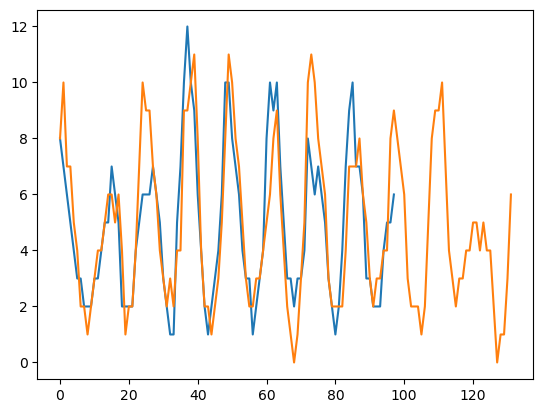

In [225]:

temp_cols = [i for i in test_df.columns if 'lai_a' in i]
plt.plot(test_df[temp_cols].iloc[96].tolist()[0])

temp_cols = [i for i in test_df.columns if 'lai_b' in i]
plt.plot(test_df[temp_cols].iloc[96].tolist()[0])
# .plot(label='LAI',color='green')
# plt.legend(loc='upper right')

In [226]:
# Check how many nan values are in each variable
nan_dictionary = {'slope': 0, 'chili':0, 'elevation':0, 'aspect':0, 'severity':0, 'mtpi':0, 'precip':0, 'temp':0, 'ndvi_before':0, 'lai_before':0,'vcf_tree_before':0, 'ndvi_after':0, 'lai_after':0, 'vcf_tree_after':0}
for val, row in all_gdf.iterrows():
#   print(val) #0-315 repeating
#   print(row)
  for i, lis in enumerate(row.values):
    if type(lis) == list:
      #print(row.index[i]) #slope, aspect, chili etc.
#       nans = nan_dictionary[row.index[i]]
    
#       if nans>0:
#           print("nans",nans)
#           row.index[i]
#           #print(lis)
#       if sum(np.isnan(lis))>0:
#           print(sum(np.isnan(lis)))
      
      nan_dictionary[row.index[i]] = nan_dictionary[row.index[i]] + sum(np.isnan(lis))
#     else:
#         print('not list')
# Severity has a disproportionate amount of nan values, we dropped it from the analysis to keep as many points as possible
nan_dictionary
#this code doesn't count corectly in each variable I think?
# print(2244/17) = 132 timesteps
#NOTE: in future there are no errors in dyn stack potentially bc the no data value is 0/not recognized as a ND value?

{'slope': 0,
 'chili': 0,
 'elevation': 0,
 'aspect': 0,
 'severity': 0,
 'mtpi': 0,
 'precip': 0,
 'temp': 0,
 'ndvi_before': 0,
 'lai_before': 0,
 'vcf_tree_before': 0,
 'ndvi_after': 0,
 'lai_after': 0,
 'vcf_tree_after': 0}

In [227]:
# create table that has each fire, # of points in the fire bound, and whether
# fire is designated as training or test
#and at the bottom, the total # of training and test points

#These parameters must be 2D lists, in which the outer lists define the rows and
#the inner list define the column values per row.
train_lab = ["Train" for i in range(len(train_id_dict))]
test_lab = ["Test" for i in range(len(test_id_dict))]

# range_pt_ids =[i[1] for i in list(train_id.values)]
num_pts_list = [i[0] for i in list(train_id_dict.values())]+[i[0] for i in list(test_id_dict.values())]
range_pts_list = [i[1] for i in list(train_id_dict.values())]+[i[1] for i in list(test_id_dict.values())]
print(len(range_pts_list),len(num_pts_list))
print(sum(num_pts_list),"is total number of points")
print("Train fires:",list(train_id_dict.keys()))
print("Test fires:",list(test_id_dict.keys()))


table_list =  pd.DataFrame({"Set":train_lab+test_lab,
                            "MTBS Fire ID": list(train_id_dict.keys())+list(test_id_dict.keys()),
                            "Num. Points (pre null filter)": num_pts_list
                            # "Range Point IDs":range_pts_list
                            })
table_list
# col_labels = ["MTBS Fire ID","# Points","Set (Train or Test)"]
# row_labels = [""]



29 29
998 is total number of points
Train fires: ['CO3709810719920101012', 'CO3726810830320120622', 'CO3740210724320120513', 'CO3741010757920121016', 'CO3747210346920110607', 'CO3781310546020100606', 'CO3812310818320100522', 'CO3817710507320121023', 'CO3823310568320110612', 'CO3825210820820110803', 'CO3843610898920120525', 'CO3872810860220100712', 'CO3888410493320120623', 'CO3894510543620120617', 'CO3925110844620110807', 'CO3935510767920100507', 'CO3943610521720120326', 'CO3970610755420100628', 'CO3976210526320110320', 'CO4005110538520100906', 'CO4036110556320121009', 'CO4053710538120110401', 'CO4054610858420100720', 'CO4058910540420120609', 'NM3692010445620110612']
Test fires: ['NM3696310515520100523', 'NM3700010423620110526', 'UT3967210907720100826', 'UT3977510922020120629']


,Set,MTBS Fire ID,Num. Points (pre null filter)
0,Train,CO3709810719920101012,5
1,Train,CO3726810830320120622,43
2,Train,CO3740210724320120513,94
3,Train,CO3741010757920121016,9
4,Train,CO3747210346920110607,53
5,Train,CO3781310546020100606,18
6,Train,CO3812310818320100522,10
7,Train,CO3817710507320121023,9
8,Train,CO3823310568320110612,18
9,Train,CO3825210820820110803,2


In [228]:
train_id = ['NM3692010445620110612','CO3817710507320121023', 'CO3970610755420100628', 'CO3843610898920120525', 'CO3872810860220100712', 'CO4036110556320121009', 'UT3967210907720100826', 'CO3888410493320120623', 'CO3740210724320120513', 'CO3825210820820110803', 'UT3977510922020120629', 'CO4058910540420120609', 'CO3812310818320100522', 'CO4054610858420100720', 'CO4053710538120110401', 'CO3823310568320110612', 'CO3976210526320110320', 'CO3925110844620110807', 'CO3709810719920101012', 'CO3781310546020100606']
val_id = ['CO3726810830320120622', 'CO3935510767920100507', 'CO4005110538520100906', 'CO3943610521720120326']
test_id = ['CO3747210346920110607', 'NM3700010423620110526', 'NM3696310515520100523', 'CO3741010757920121016', 'CO3894510543620120617'] #removed: 'CO3740210724320120513'
#NOTE: swapped little sand fire into test and track fire into train! 11-22-23

for i in val_id:
    if i in test_id or i in train_id:
        print(i)

## Viz train vs. test fire bounds

In [229]:

#note that there are 29 IDs here vs. 28 fires that data are split on bc one fire crosses the CO/UT border
#and thus has 2 dif Event_ID values for it

#seperate fires from fire_bounds in training set and test set

list_train_id = list(set(train_id))
list_val_id = list(set(val_id))
list_test_id = list(set(test_id))

mask = fire_bounds_dates['Event_ID'].isin(list_train_id)
mask_val = fire_bounds_dates['Event_ID'].isin(list_val_id)
mask_test = fire_bounds_dates['Event_ID'].isin(list_test_id)

train_fire_bounds = fire_bounds_dates[mask]
val_fire_bounds = fire_bounds_dates[mask_val]
test_fire_bounds = fire_bounds_dates[mask_test]


print(len(train_fire_bounds), len(val_fire_bounds), len(test_fire_bounds))

20 4 5


/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


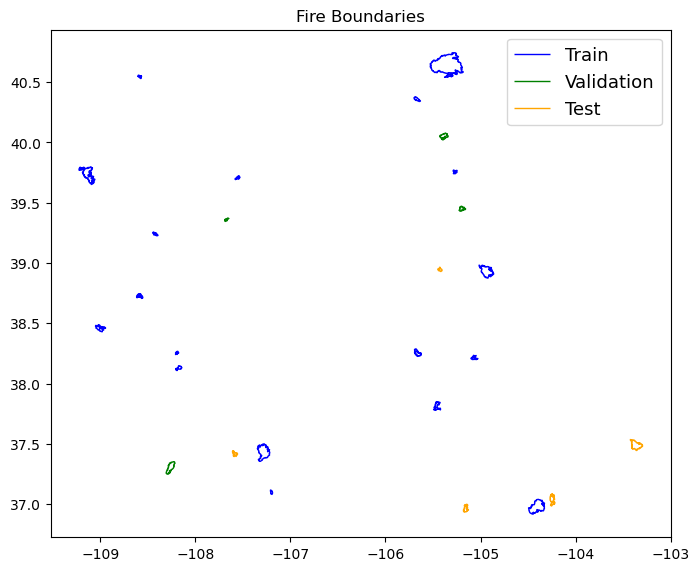

In [230]:

fig, ax = plt.subplots(figsize=(8, 8))
train_fire_bounds.boundary.plot(ax=ax, color='blue', linewidth=1, label='Train')
val_fire_bounds.boundary.plot(ax=ax, color='green', linewidth=1, label='Validation')
test_fire_bounds.boundary.plot(ax=ax, color='orange', linewidth=1, label='Test')
plt.title("Fire Boundaries")
plt.legend(loc='upper right')
# plt.text(2,4,'This text starts at point (2,4)')
plt.savefig("Training_vs_Test_Fire_Bounds",dpi=300)


# plt.show()


/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


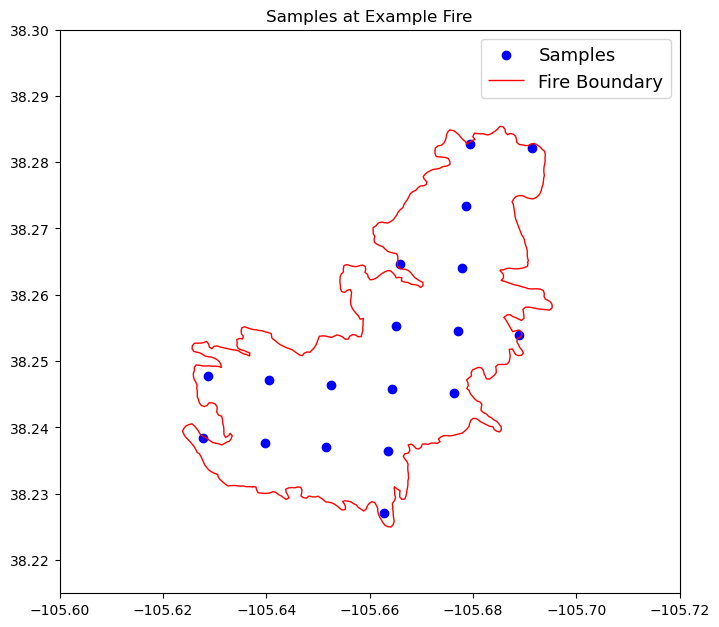

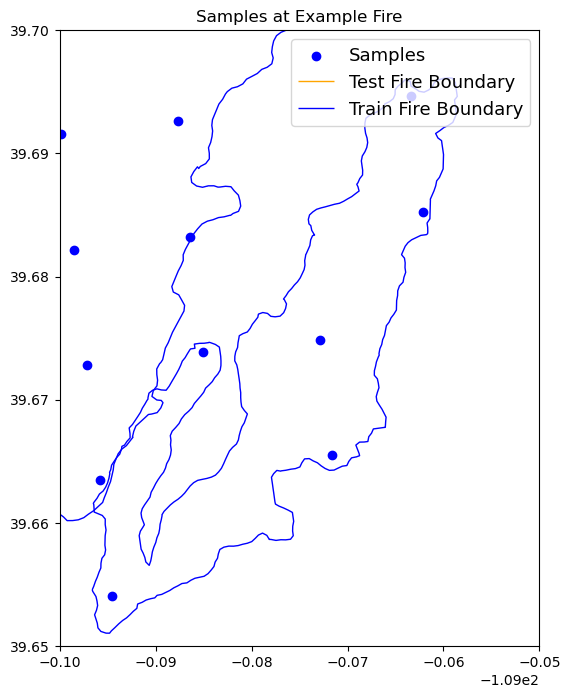

In [231]:
fig, ax = plt.subplots(figsize=(8, 8))
points_shp.plot(ax=ax, color='blue', label='Samples')
train_fire_bounds.boundary.plot(ax=ax, color='red', linewidth=1, label='Fire Boundary')
plt.title("Samples at Example Fire")
plt.legend(loc='upper right')

plt.xlim(-105.6, -105.72)
plt.ylim(38.215,38.3)

plt.savefig("ExampleFire_WithPoints.png",dpi=300)

fig, ax = plt.subplots(figsize=(8, 8))
points_shp.plot(ax=ax, color='blue', label='Samples')
test_fire_bounds.boundary.plot(ax=ax, color='orange', linewidth=1, label='Test Fire Boundary')
train_fire_bounds.boundary.plot(ax=ax, color='blue', linewidth=1, label='Train Fire Boundary')

plt.title("Samples at Example Fire")
plt.legend(loc='upper right')

# plt.xlim(-109.25, -109.05)
# plt.ylim(39.65,39.8)
plt.xlim(-109.1, -109.05)
plt.ylim(39.65,39.7)

plt.savefig("ExampleFire2_WithPoints.png",dpi=300)



## Fill NaN values in NDVI_Before series in dataframes

In [232]:
# #check what nan values might look like
# print(test_df.ndvi_before.values[9:12])

# print(test_df.lai_before.values[4:6])

In [233]:
# forward-fill NaN values in ndvi_before in dataframes

# this commented code is to replace nan with mean of series
# for list_i in range(len(test_df_fillf.ndvi_before.values)):
#   mn = np.nanmean(test_df_fillf.ndvi_before.values[list_i])
#   print(mn)
#   new_l = np.nan_to_num(test_df_fillf.ndvi_before.values[list_i], nan=mn)
#   test_df_fillf.ndvi_before.values[list_i] = list(new_l)
for list_i in range(len(test_df.ndvi_before.values)):
  df_temp = pd.Series(test_df.ndvi_before.values[list_i])
  new_l = df_temp.fillna(method='ffill')
  # print(new_l)
  test_df.ndvi_before.values[list_i] = list(new_l)

for list_i in range(len(train_df.ndvi_before.values)):
  df_temp = pd.Series(train_df.ndvi_before.values[list_i])
  new_l = df_temp.fillna(method='ffill')
  # print(new_l)
  train_df.ndvi_before.values[list_i] = list(new_l)

for list_i in range(len(val_df.ndvi_before.values)):
  df_temp = pd.Series(val_df.ndvi_before.values[list_i])
  new_l = df_temp.fillna(method='ffill')
  # print(new_l)
  val_df.ndvi_before.values[list_i] = list(new_l)



  



In [234]:
# for list_i in range(len(test_df.lai_before.values)):
#   df_temp = pd.Series(test_df.lai_before.values[list_i])
#   new_l = df_temp.fillna(method='ffill')
#   # print(new_l)
#   test_df.ndvi_before.values[list_i] = list(new_l)

# for list_i in range(len(train_df.lai_before.values)):
#   df_temp = pd.Series(train_df.lai_before.values[list_i])
#   new_l = df_temp.fillna(method='ffill')
#   # print(new_l)
#   train_df.ndvi_before.values[list_i] = list(new_l)

# for list_i in range(len(val_df.lai_before.values)):
#   df_temp = pd.Series(val_df.lai_before.values[list_i])
#   new_l = df_temp.fillna(method='ffill')
#   # print(new_l)
#   val_df.ndvi_before.values[list_i] = list(new_l)

In [235]:
test_df.head()

,slope,chili,elevation,aspect,severity,geometry,Event_ID,mtpi,precip,temp,ndvi_before,lai_before,vcf_tree_before,ndvi_after,lai_after,vcf_tree_after
96,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....","[198.0, 198.0, 198.0, 198.0, 198.0, 198.0, 198...","[2659.1353, 2659.1353, 2659.1353, 2659.1353, 2...","[0.2923717, 0.2923717, 0.2923717, 0.2923717, 0...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",POINT (-107.568308477704 37.41804088464445),CO3741010757920121016,"[24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24....","[2.43, 1.74, 1.48, 0.37, 3.31, 1.78, 0.68, 0.6...","[12.03, 7.75, 2.45, 7.49, 3.46, 8.17, 11.73, 1...","[3081.0, 1363.0, 90.0, 724.0, 89.0, 365.5, 186...","[3, 1, 1, 1, 0, 1, 3, 5, 11, 12, 12, 11, 7, 2,...","[24, 24, 24, 28, 28, 28, 28, 28, 28, 28, 28, 2...","[4439.0, 2414.0, 932.0, 574.0, 710.0, 1431.0, ...","[5, 2, 1, 0, 0, 1, 6, 10, 23, 20, 20, 13, 6, 3...","[20, 20, 20, 22, 22, 22, 22, 22, 22, 22, 22, 2..."
97,"[32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32....","[192.0, 192.0, 192.0, 192.0, 192.0, 192.0, 192...","[2981.6348, 2981.6348, 2981.6348, 2981.6348, 2...","[-0.60181504, -0.60181504, -0.60181504, -0.601...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",POINT (-107.6056666816126 37.4342031772499),CO3741010757920121016,"[-21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21...","[2.54, 1.76, 1.64, 0.52, 3.6, 1.76, 0.73, 0.3,...","[9.15, 5.63, 0.64, 5.75, 1.93, 6.73, 9.05, 14....","[4604.0, 2667.0, 1327.5, 1061.0, 984.0, 859.0,...","[3, 2, 2, 1, 2, 2, 3, 4, 7, 11, 7, 6, 3, 1, 1,...","[20, 20, 20, 26, 26, 26, 26, 26, 26, 26, 26, 2...","[4517.0, 1864.5, -80.0, 773.5, 415.0, 2039.0, ...","[5, 2, 1, 2, 1, 1, 3, 5, 13, 13, 13, 12, 6, 3,...","[16, 16, 16, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
98,"[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....","[224.0, 224.0, 224.0, 224.0, 224.0, 224.0, 224...","[2818.7395, 2818.7395, 2818.7395, 2818.7395, 2...","[-0.9945219, -0.9945219, -0.9945219, -0.994521...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",POINT (-107.5800460907334 37.41718845488872),CO3741010757920121016,"[46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46....","[2.44, 1.73, 1.53, 0.43, 3.42, 1.85, 0.68, 0.6...","[10.98, 6.99, 1.8, 6.87, 2.93, 7.66, 10.77, 16...","[4103.0, 2275.5, 980.5, 1142.0, 633.0, 435.5, ...","[1, 1, 1, 1, 0, 1, 2, 2, 11, 13, 13, 11, 5, 1,...","[20, 20, 20, 22, 22, 22, 22, 22, 22, 22, 22, 2...","[4674.0, 2564.5, 551.0, 333.5, 521.5, 1374.5, ...","[6, 1, 0, 0, 0, 2, 6, 8, 19, 18, 19, 17, 7, 3,...","[26, 26, 26, 13, 13, 13, 13, 13, 13, 13, 13, 1..."
99,"[25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25....","[153.0, 153.0, 153.0, 153.0, 153.0, 153.0, 153...","[2861.94, 2861.94, 2861.94, 2861.94, 2861.94, ...","[-0.034899496, -0.034899496, -0.034899496, -0....","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",POINT (-107.5928547479472 37.42569654401495),CO3741010757920121016,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[2.49, 1.75, 1.58, 0.48, 3.51, 1.8, 0.71, 0.52...","[9.99, 6.27, 1.18, 6.28, 2.39, 7.15, 9.84, 15....","[5262.0, 3772.5, 2114.0, 2164.5, 1627.5, 687.5...","[3, 2, 2, 2, 1, 2, 3, 5, 13, 12, 14, 7, 4, 2, ...","[31, 31, 31, 38, 38, 38, 38, 38, 38, 38, 38, 3...","[4571.0, 2768.0, 665.5, 761.0, 426.5, 1137.5, ...","[5, 2, 1, 1, 1, 1, 4, 7, 15, 21, 14, 11, 5, 2,...","[31, 31, 31, 17, 17, 17, 17, 17, 17, 17, 17, 1..."
100,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....","[223.0, 223.0, 223.0, 223.0, 223.0, 223.0, 223...","[2661.9556, 2661.9556, 2661.9556, 2661.9556, 2...","[-0.9335804, -0.9335804, -0.9335804, -0.933580...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",POINT (-107.5907123590304 37.40697300005408),CO3741010757920121016,"[9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, ...","[2.38, 1.71, 1.48, 0.37, 3.31, 1.79, 0.64, 0.5...","[11.97, 7.71, 2.4, 7.44, 3.46, 8.16, 11.75, 17...","[2934.0, 2508.5, -122.0, 297.0, 970.5, 1597.5,...","[1, 0, 0, 0, 0, 1, 1, 2, 5, 7, 7, 5, 4, 1, 0, ...","[14, 14, 14, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[4190.0, 2022.5, 

In [236]:
print(test_df.ndvi_before.values[10])
print(test_df.ndvi_after.values[10])
print(train_df.ndvi_after.values[10])

[3706.5, 3870.5, 3684.5, 3764.5, 3812.0, 4294.0, 4244.5, 4090.0, 3790.0, 3478.0, 3452.5, 3255.5, 3237.0, 3153.5, 3237.5, 3401.5, 3570.0, 3807.5, 2422.0, 4403.5, 3730.5, 3475.0, 3481.0, 3553.5, 3537.5, 3426.0, 3752.0, 3739.5, 3687.0, 3879.5, 3929.0, 4036.5, 3549.0, 3330.5, 3577.5, 3534.0, 3520.0, 3963.5, 3793.5, 3835.0, 3918.5, 4650.0, 4406.0, 4516.5, 3899.5, 3690.0, 3745.5, 4201.0, 3940.5, 3785.0, 4058.0, 4213.5, 4174.0, 4128.5, 4328.0, 4212.0, 3841.0, 3535.0, 3409.5, 3238.5, 3683.0, 3704.5, 4183.0, 4147.0, 4171.0, 4117.0, 2296.5, 865.0, 2316.0, 3606.5, 3818.5, 4005.0, 4067.0, 4083.0, 4248.5, 4365.0, 4320.0, 4098.5, 4191.5, 3990.0, 3877.5, 3619.5, 3365.5, 3491.0, 3620.5, 3674.0, 3946.5, 4198.0, 4307.0, 3961.0, 4236.0, 4077.0, 3805.5, 3379.0, 3425.0, 3560.5, 3619.0, 3796.5, 4011.5, 4091.5, 3801.0, 4491.5, 4251.0, 4370.5, 4189.5, 3554.5, 3636.0, 4163.0, 3853.0, 4205.0, 4065.5, 3978.0, 3969.0, 4157.0, 4208.0, 4377.5, 3949.0, 3522.0, 3223.5, 3190.5, 1986.5, 2082.5, 2115.0, 1975.5, 1850.0, 

In [237]:
#save test df
# save train df
# save val df
#NOTE: to run this, need to make sure you don't delete the "geometry" fields in earlier attribute lists

test_df_limited=test_df[['Event_ID','geometry']].copy() #may not work when including 'Event_ID'
test_gdf = gpd.GeoDataFrame(test_df_limited, geometry='geometry')
test_gdf.to_file('test_df_points.shp')


train_df_limited=train_df[['Event_ID','geometry']].copy()
train_gdf = gpd.GeoDataFrame(train_df_limited, geometry='geometry')
train_gdf.to_file('train_df_points.shp')


val_df_limited=val_df[['Event_ID','geometry']].copy()
val_gdf = gpd.GeoDataFrame(val_df_limited, geometry='geometry')
val_gdf.to_file('val_df_points.shp')


/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


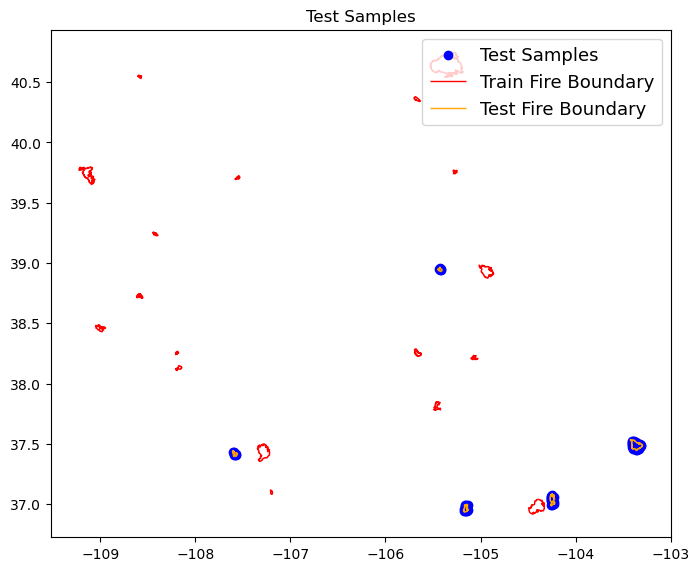

In [238]:
# viz point split: confirm all test samples are in test fire bounds
fig, ax = plt.subplots(figsize=(8, 8))
test_gdf.plot(ax=ax, color='blue', label='Test Samples')
train_fire_bounds.boundary.plot(ax=ax, color='red', linewidth=1, label='Train Fire Boundary')
test_fire_bounds.boundary.plot(ax=ax, color='orange', linewidth=1, label='Test Fire Boundary')

plt.title("Test Samples")
plt.legend(loc='upper right')

In [239]:
test_df.head()

,slope,chili,elevation,aspect,severity,geometry,Event_ID,mtpi,precip,temp,ndvi_before,lai_before,vcf_tree_before,ndvi_after,lai_after,vcf_tree_after
96,"[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....","[198.0, 198.0, 198.0, 198.0, 198.0, 198.0, 198...","[2659.1353, 2659.1353, 2659.1353, 2659.1353, 2...","[0.2923717, 0.2923717, 0.2923717, 0.2923717, 0...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",POINT (-107.568308477704 37.41804088464445),CO3741010757920121016,"[24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24....","[2.43, 1.74, 1.48, 0.37, 3.31, 1.78, 0.68, 0.6...","[12.03, 7.75, 2.45, 7.49, 3.46, 8.17, 11.73, 1...","[3081.0, 1363.0, 90.0, 724.0, 89.0, 365.5, 186...","[3, 1, 1, 1, 0, 1, 3, 5, 11, 12, 12, 11, 7, 2,...","[24, 24, 24, 28, 28, 28, 28, 28, 28, 28, 28, 2...","[4439.0, 2414.0, 932.0, 574.0, 710.0, 1431.0, ...","[5, 2, 1, 0, 0, 1, 6, 10, 23, 20, 20, 13, 6, 3...","[20, 20, 20, 22, 22, 22, 22, 22, 22, 22, 22, 2..."
97,"[32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32....","[192.0, 192.0, 192.0, 192.0, 192.0, 192.0, 192...","[2981.6348, 2981.6348, 2981.6348, 2981.6348, 2...","[-0.60181504, -0.60181504, -0.60181504, -0.601...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",POINT (-107.6056666816126 37.4342031772499),CO3741010757920121016,"[-21.0, -21.0, -21.0, -21.0, -21.0, -21.0, -21...","[2.54, 1.76, 1.64, 0.52, 3.6, 1.76, 0.73, 0.3,...","[9.15, 5.63, 0.64, 5.75, 1.93, 6.73, 9.05, 14....","[4604.0, 2667.0, 1327.5, 1061.0, 984.0, 859.0,...","[3, 2, 2, 1, 2, 2, 3, 4, 7, 11, 7, 6, 3, 1, 1,...","[20, 20, 20, 26, 26, 26, 26, 26, 26, 26, 26, 2...","[4517.0, 1864.5, -80.0, 773.5, 415.0, 2039.0, ...","[5, 2, 1, 2, 1, 1, 3, 5, 13, 13, 13, 12, 6, 3,...","[16, 16, 16, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
98,"[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....","[224.0, 224.0, 224.0, 224.0, 224.0, 224.0, 224...","[2818.7395, 2818.7395, 2818.7395, 2818.7395, 2...","[-0.9945219, -0.9945219, -0.9945219, -0.994521...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",POINT (-107.5800460907334 37.41718845488872),CO3741010757920121016,"[46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46....","[2.44, 1.73, 1.53, 0.43, 3.42, 1.85, 0.68, 0.6...","[10.98, 6.99, 1.8, 6.87, 2.93, 7.66, 10.77, 16...","[4103.0, 2275.5, 980.5, 1142.0, 633.0, 435.5, ...","[1, 1, 1, 1, 0, 1, 2, 2, 11, 13, 13, 11, 5, 1,...","[20, 20, 20, 22, 22, 22, 22, 22, 22, 22, 22, 2...","[4674.0, 2564.5, 551.0, 333.5, 521.5, 1374.5, ...","[6, 1, 0, 0, 0, 2, 6, 8, 19, 18, 19, 17, 7, 3,...","[26, 26, 26, 13, 13, 13, 13, 13, 13, 13, 13, 1..."
99,"[25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25....","[153.0, 153.0, 153.0, 153.0, 153.0, 153.0, 153...","[2861.94, 2861.94, 2861.94, 2861.94, 2861.94, ...","[-0.034899496, -0.034899496, -0.034899496, -0....","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",POINT (-107.5928547479472 37.42569654401495),CO3741010757920121016,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[2.49, 1.75, 1.58, 0.48, 3.51, 1.8, 0.71, 0.52...","[9.99, 6.27, 1.18, 6.28, 2.39, 7.15, 9.84, 15....","[5262.0, 3772.5, 2114.0, 2164.5, 1627.5, 687.5...","[3, 2, 2, 2, 1, 2, 3, 5, 13, 12, 14, 7, 4, 2, ...","[31, 31, 31, 38, 38, 38, 38, 38, 38, 38, 38, 3...","[4571.0, 2768.0, 665.5, 761.0, 426.5, 1137.5, ...","[5, 2, 1, 1, 1, 1, 4, 7, 15, 21, 14, 11, 5, 2,...","[31, 31, 31, 17, 17, 17, 17, 17, 17, 17, 17, 1..."
100,"[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....","[223.0, 223.0, 223.0, 223.0, 223.0, 223.0, 223...","[2661.9556, 2661.9556, 2661.9556, 2661.9556, 2...","[-0.9335804, -0.9335804, -0.9335804, -0.933580...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",POINT (-107.5907123590304 37.40697300005408),CO3741010757920121016,"[9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, ...","[2.38, 1.71, 1.48, 0.37, 3.31, 1.79, 0.64, 0.5...","[11.97, 7.71, 2.4, 7.44, 3.46, 8.16, 11.75, 17...","[2934.0, 2508.5, -122.0, 297.0, 970.5, 1597.5,...","[1, 0, 0, 0, 0, 1, 1, 2, 5, 7, 7, 5, 4, 1, 0, ...","[14, 14, 14, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[4190.0, 2022.5, 

### Subset out predictor columns

In [240]:
# Read test and train data frames into numpy arrays
#LSTM_slope_chili_elevation_aspect_severity_mtpi_precip_temp_ndvi_before_lai_before_units50_3lstmlayers.keras

use_these_bands = ['slope' ,'chili', 'elevation', 'aspect', 'mtpi', 'precip', 
                   'temp', 'ndvi_before','lai_before', 'severity', 'vcf_tree_before']#-> replaced w severity
#should be same at feat_names in ablation study loop


#should be same at feat_names in ablation study loop

x_test_names_forFig = test_df['Event_ID'].values.tolist()

print(pd.DataFrame(test_df[use_these_bands]).head())#.columns)
x_test_df = test_df[use_these_bands].values.tolist()
x_train_df = train_df[use_these_bands].values.tolist()
x_val_df = val_df[use_these_bands].values.tolist()

y_test_df1 = test_df[['ndvi_after']].values.tolist()
y_train_df1 = train_df[['ndvi_after']].values.tolist()
y_val_df1 = val_df[['ndvi_after']].values.tolist()

y_test_df2 = test_df[['lai_after']].values.tolist()
y_train_df2 = train_df[['lai_after']].values.tolist()
y_val_df2 = val_df[['lai_after']].values.tolist()


y_test_df3 = test_df[['vcf_tree_after']].values.tolist()
y_train_df3 = train_df[['vcf_tree_after']].values.tolist()
y_val_df3 = val_df[['vcf_tree_after']].values.tolist()

test_geom = test_df[['geometry', 'Event_ID']].values.tolist()



# len(x_test_df), len(x_train_df), len(y_test_df1), len(y_test_df2), len(y_train_df1), len(y_val_df1)


                                                 slope  \
96   [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10....   
97   [32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32....   
98   [11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11....   
99   [25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25....   
100  [14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14....   

                                                 chili  \
96   [198.0, 198.0, 198.0, 198.0, 198.0, 198.0, 198...   
97   [192.0, 192.0, 192.0, 192.0, 192.0, 192.0, 192...   
98   [224.0, 224.0, 224.0, 224.0, 224.0, 224.0, 224...   
99   [153.0, 153.0, 153.0, 153.0, 153.0, 153.0, 153...   
100  [223.0, 223.0, 223.0, 223.0, 223.0, 223.0, 223...   

                                             elevation  \
96   [2659.1353, 2659.1353, 2659.1353, 2659.1353, 2...   
97   [2981.6348, 2981.6348, 2981.6348, 2981.6348, 2...   
98   [2818.7395, 2818.7395, 2818.7395, 2818.7395, 2...   
99   [2861.94, 2861.94, 2861.94, 2861.94, 2861.94, ...   
100  [2661.9

In [241]:
#create copy of test data to store IDs
x_test_df_storeIDs = test_df[['Event_ID']].values#.tolist() #assumes no values are removed in next step
# print(x_test_df_storeIDs)

## Remove NaNs

In [242]:
#NOTE: as of 2/7/23, NDVI_before is the limiting factor here
x_test_names_forFig =np.array(x_test_names_forFig)[~np.isnan(np.array(x_test_df)).any(axis=(1,2))]

X_test = np.array(x_test_df)[~np.isnan(np.array(x_test_df)).any(axis=(1,2))]
X_train = np.array(x_train_df)[~np.isnan(np.array(x_train_df)).any(axis=(1,2))]
X_val = np.array(x_val_df)[~np.isnan(np.array(x_val_df)).any(axis=(1,2))]

y_test1 = np.array(y_test_df1)[~np.isnan(np.array(x_test_df)).any(axis=(1,2))]
y_train1=  np.array(y_train_df1)[~np.isnan(np.array(x_train_df)).any(axis=(1,2))]
y_val1 = np.array(y_val_df1)[~np.isnan(np.array(x_val_df)).any(axis=(1,2))]

y_test2 = np.array(y_test_df2)[~np.isnan(np.array(x_test_df)).any(axis=(1,2))]
y_train2= np.array(y_train_df2)[~np.isnan(np.array(x_train_df)).any(axis=(1,2))]
y_val2 = np.array(y_val_df2)[~np.isnan(np.array(x_val_df)).any(axis=(1,2))]


y_test3, y_train3, y_val3 = np.array(y_test_df3)[~np.isnan(np.array(x_test_df)).any(axis=(1,2))], np.array(y_train_df3)[~np.isnan(np.array(x_train_df)).any(axis=(1,2))],np.array(y_val_df3)[~np.isnan(np.array(x_val_df)).any(axis=(1,2))]

test_geom = np.array(test_geom)[~np.isnan(np.array(x_test_df)).any(axis=(1,2))]

#reformat labels
x_test_list_storeIDs = np.array(x_test_df_storeIDs)#[~np.isnan(np.array(x_test_df_storeIDs)).any(axis=(1,2))]
print("label shp:", x_test_list_storeIDs.shape)
print('X Val:',X_val.shape, 'y val:',y_val1.shape)
print('X_train:',X_train.shape, 'y train:', y_train1.shape)
print('X Test:',X_test.shape, 'y test:',y_test1.shape)
print("Note: shape format is #samples, #features, # of timesteps\n")

tot = y_train1.shape[0]+y_test1.shape[0]+y_val1.shape[0]
print("train/val/test point split",y_train1.shape[0]/tot,"/",y_val1.shape[0]/tot,"/",y_test1.shape[0]/tot )

#have we removed points?
print("prev shape of test was:",x_test_df_storeIDs.shape) #first shape 0 should match


label shp: (111, 1)
X Val: (81, 11, 132) y val: (81, 1, 98)
X_train: (806, 11, 132) y train: (806, 1, 98)
X Test: (111, 11, 132) y test: (111, 1, 98)
Note: shape format is #samples, #features, # of timesteps

train/val/test point split 0.8076152304609219 / 0.0811623246492986 / 0.11122244488977956
prev shape of test was: (111, 1)


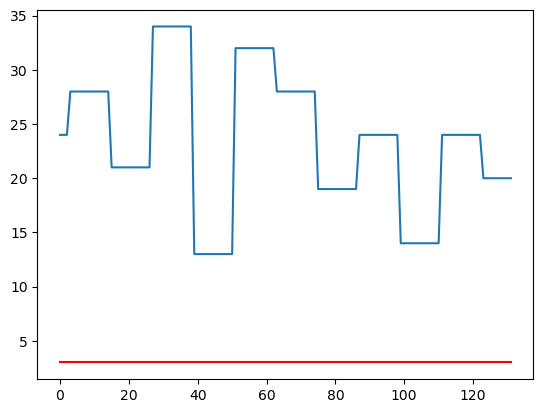

In [243]:
plt.plot(X_train[0,9,:], color='red', label = "vcf")
plt.plot(X_test[0,10,:], label="severity ")

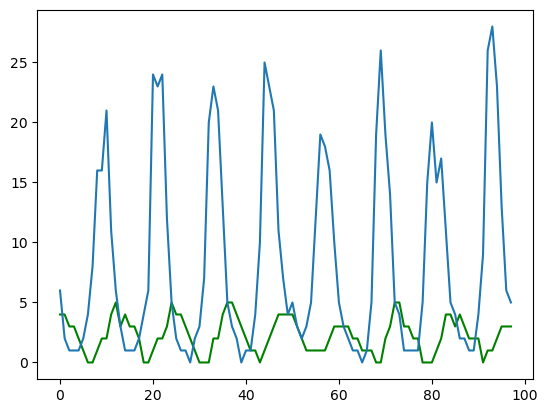

In [244]:
plt.plot(y_train2[80][0], color='green')

plt.plot(y_test2[7][0])

## Standardize Data

Test Viz + look at means of NDVI to ensure the train/test/x/y are on approx. same scale of values


(806, 11, 132) is x train shape
(111, 11, 132) is x test shp
(111, 1, 98) is y test1 shp
MEAN VCF X_train: 2.662531017369727
MEAN NDVI xtrain 4523.571086171893
MEAN NDVI X_test: 3085.3063063063064
MEAN NDVI y_test1: 3294.427927927928
(111, 1, 98)
(111, 11, 132)


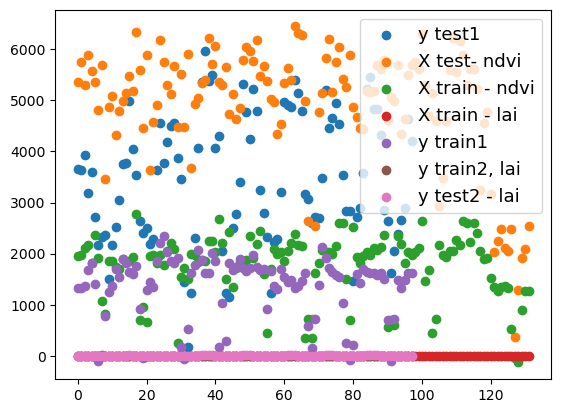

In [245]:
print(X_train.shape, 'is x train shape')#(702, 10, 132)
print(X_test.shape, 'is x test shp')
# print(y_test.shape,"is y test shp")
print(y_test1.shape,"is y test1 shp")

print("MEAN VCF X_train:", np.mean(X_train[:,9,:])) #all samples, variable 9(vcf_tree), all timesteps
print("MEAN NDVI xtrain", np.mean(X_train[:,7,:])) #all samples, variable 7(ndvi), all timesteps
# pre-standardizing mean X train is like 4104.9; post-standardizing mean xtrain is -0.286
print("MEAN NDVI X_test:", np.mean(X_test[:,7,91])) #all samples, at month 9, variable 7(ndvi)
print("MEAN NDVI y_test1:", np.mean(y_test1[:,0,34])) #all samples, at month 34, variable 0(ndvi)

#these 2 are created below?
# print("MEAN NDVI y_test:", np.mean(y_test[:,34,0])) #all samples, at month 34, variable 0(ndvi)

# print("MEAN NDVI y train:", np.mean(y_train[:,7,0])) #all samples, at month 9, variable 7(ndvi)


m_ind = 99
plt.scatter(range(98),y_test1[m_ind,:], label="y test1") #range of NDVI is around 0 - 400
# plt.scatter(range(98),y_test[m_ind,:,0], label="y test") #range of NDVI is around 0 - 400

print(y_test1.shape)
print(X_test.shape)
# print(y_test.shape)
plt.scatter(range(132),X_test[m_ind,7,:], label = "X test- ndvi") #plot NDVI
plt.scatter(range(132),X_train[m_ind,7,:], label="X train - ndvi") #plot NDVI
plt.scatter(range(132),X_train[m_ind,7+1,:], label="X train - lai") #plot NDVI

plt.scatter(range(98),y_train1[m_ind,:],label = "y train1") #plot NDVI
plt.scatter(range(98),y_train2[m_ind,:],label = "y train2, lai") #plot lai
plt.scatter(range(98),y_test2[m_ind,:],label = "y test2 - lai") #plot lai

plt.legend()


# MEAN VCF X_train: 2.662531017369727
# MEAN NDVI xtrain 4514.483095533499
# MEAN NDVI X_test: 3212.801801801802
# MEAN NDVI y_test1: 3990.463963963964

(111, 1, 98)
(111, 11, 132)


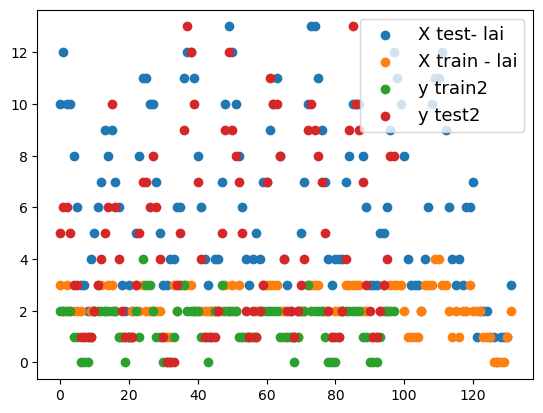

In [246]:
#test LAI x and y train and test

m_ind = 99
# plt.scatter(range(98),y_test[m_ind,:,0], label="y test") #range of NDVI is around 0 - 400

print(y_test1.shape)
print(X_test.shape)
# print(y_test.shape)
plt.scatter(range(132),X_test[m_ind,7+1,:], label = "X test- lai") #plot NDVI
plt.scatter(range(132),X_train[m_ind,7+1,:], label="X train - lai") #plot NDVI

plt.scatter(range(98),y_train2[m_ind,:],label = "y train2") #plot lai
plt.scatter(range(98),y_test2[m_ind,:],label = "y test2") #plot lai

plt.legend()


(1, 132)
106392
nz 660


array([False, False, False, ..., False, False, False])

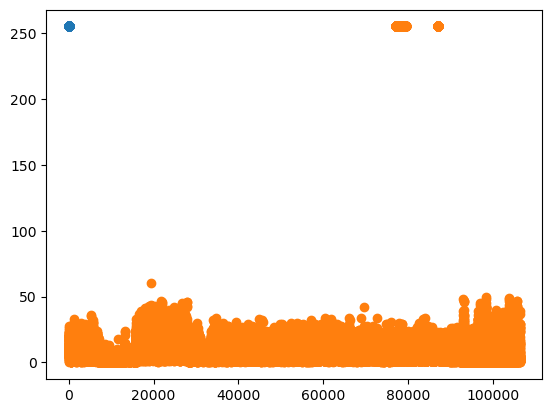

In [247]:
plt.scatter(range(len(X_train[591:592,8,:].flatten())),X_train[591:592,8,:].flatten())
plt.scatter(range(len(X_train[:,8,:].flatten())),X_train[:,8,:].flatten())
print(X_train[591:592,8,:].shape)
print(len(X_train[:,8,:].flatten()))
print("nz",np.count_nonzero(X_train[:,8,:].flatten() == 255))
660/106392
X_train[:,8,:].flatten() == 255

### replace lai values of 255 with 0

In [248]:
X_train[:,8,:][X_train[:,8,:] == 255] = 0
X_val[:,8,:][X_val[:,8,:] == 255] = 0
X_test[:,8,:][X_test[:,8,:] == 255] = 0

y_train2[:,0,:][y_train2[:,0,:] == 255] = 0
y_test2[:,0,:][y_test2[:,0,:] == 255] = 0
y_val2[:,0,:][y_val2[:,0,:] == 255] = 0

In [249]:
y_test2.shape

(111, 1, 98)

(1, 98)
78988
nz 0


array([False, False, False, ..., False, False, False])

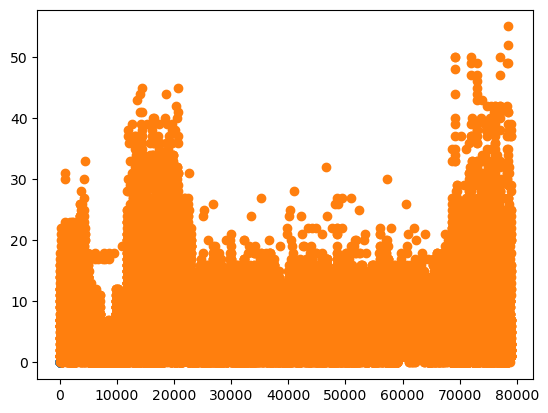

In [250]:
plt.scatter(range(len(y_train2[591:592,0,:].flatten())),y_train2[591:592,0,:].flatten())
plt.scatter(range(len(y_train2[:,0,:].flatten())),y_train2[:,0,:].flatten())
print(y_train2[591:592,0,:].shape)
print(len(y_train2[:,0,:].flatten()))
print("nz",np.count_nonzero(y_train2[:,0,:].flatten() == 255))
660/106392
y_train2[:,0,:].flatten() == 255

(0, 132)
10692
nz 0


array([False, False, False, ..., False, False, False])

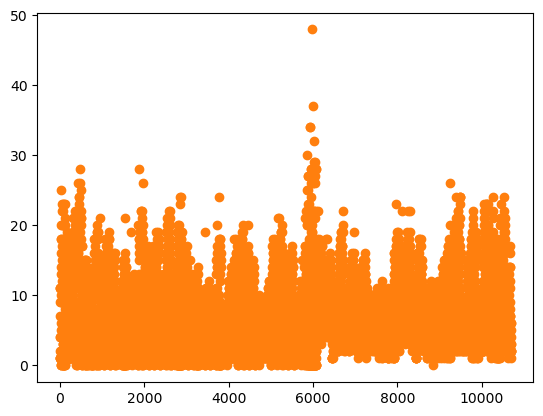

In [251]:
plt.scatter(range(len(X_val[591:592,8,:].flatten())),X_val[591:592,8,:].flatten())
plt.scatter(range(len(X_val[:,8,:].flatten())),X_val[:,8,:].flatten())
print(X_val[591:592,8,:].shape)
print(len(X_val[:,8,:].flatten()))
print("nz",np.count_nonzero(X_val[:,8,:].flatten() == 255))
660/106392
X_val[:,8,:].flatten() == 255

## Divide x_train_ndvi by 10k

In [252]:
X_train[:,7,:] = X_train[:,7,:]/10000
X_test[:,7,:] = X_test[:,7,:]/10000
X_val[:,7,:] = X_val[:,7,:]/10000

y_train1 = y_train1/10000
y_test1 = y_test1/10000
y_val1 = y_val1/10000


X_train[:,8,:] = X_train[:,8,:]*0.1
X_test[:,8,:] = X_test[:,8,:]*0.1
X_val[:,8,:] = X_val[:,8,:]*0.1

y_train2 = y_train2*0.1
y_test2 = y_test2*0.1
y_val2 = y_val2*0.1



In [253]:
y_train2.max()

5.5

(array([4.6916e+04, 1.9693e+04, 8.7160e+03, 2.2430e+03, 9.6500e+02,
        2.5900e+02, 1.2500e+02, 4.9000e+01, 1.6000e+01, 6.0000e+00]),
 array([0.  , 0.55, 1.1 , 1.65, 2.2 , 2.75, 3.3 , 3.85, 4.4 , 4.95, 5.5 ]),
 <BarContainer object of 10 artists>)

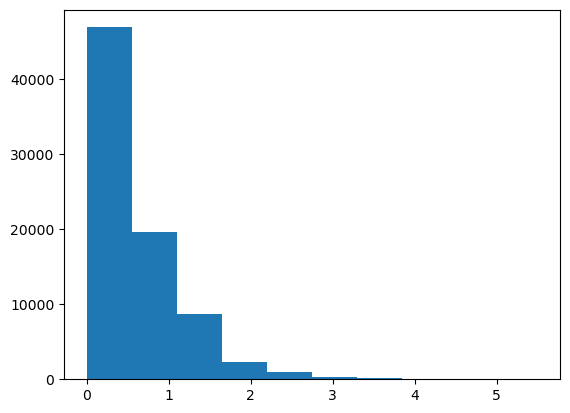

In [254]:
plt.hist(y_train2.flatten())

In [255]:
print(y_test2.min())


0.0


In [256]:
# Standardize data by hand because StandarScalar doesn't take multidimensional rasters
#NOTE this is for when we have three target vars ********************

n_samples, n_feats, n_tsteps =  X_train.shape

X_train = np.transpose(X_train,axes=(0,2,1))#reshape(n_samples, n_tsteps, n_feats)
print(X_train.shape,"is new shp")

X_train = np.array(X_train)
mean_value = np.mean(X_train, axis= (tuple(range(X_train.ndim-1))))
std_val = np.std(X_train, axis= (tuple(range(X_train.ndim-1))))
print("NDVI mean", mean_value[7])
print("LAI mean", mean_value[8])
print("NDVI std", std_val[7])
print("lai std", std_val[8])



print("orig min of ndvi:", np.min(X_train,axis= (tuple(range(X_train.ndim-1))))[7])
print("orig max of ndvi:", np.max(X_train,axis= (tuple(range(X_train.ndim-1))))[7])

print("orig min of lai:", np.min(X_train,axis= (tuple(range(X_train.ndim-1))))[8])
print("orig max of lai:", np.max(X_train,axis= (tuple(range(X_train.ndim-1))))[8])


#subtract mean and then divide by stdev

X_test = np.transpose(X_test,axes=(0,2,1))#reshape(n_samples, n_tsteps, n_feats)
X_val = np.transpose(X_val,axes=(0,2,1))#reshape(n_samples, n_tsteps, n_feats)

y_train1 = np.transpose(y_train1,axes=(0,2,1))
y_test1 =np.transpose(y_test1,axes=(0,2,1))
y_val1 = np.transpose(y_val1,axes=(0,2,1))

y_train2 = np.transpose(y_train2,axes=(0,2,1))
y_test2=np.transpose(y_test2,axes=(0,2,1))
y_val2 = np.transpose(y_val2,axes=(0,2,1))

y_train3 = np.transpose(y_train3,axes=(0,2,1))
y_test3=np.transpose(y_test3,axes=(0,2,1))
y_val3 = np.transpose(y_val3,axes=(0,2,1))


print(y_test1.shape, "is post transpose y shape")

# min_lai = np.min(X_train[:,:,8])
# max_lai = np.max(X_train[:,:,8])

# X_train[:,:,8] = (X_train[:,:,8] - min_lai)/ (max_lai - min_lai)
# X_val[:,:,8] = (X_val[:,:,8] - min_lai)/ (max_lai - min_lai)
# X_test[:,:,8] = (X_test[:,:,8] - min_lai)/ (max_lai - min_lai)
X_train = (X_train - mean_value)/std_val
X_test = (X_test - mean_value)/std_val
X_val = (X_val - mean_value)/std_val


# if the y_test is just a 2d array ie list of ndvi values over n monthls, then we just want to take the last mean value.
# BUT if y_test i.e. the target has threee different variables to predict (i.e lai, ndvi and vcf..), then we need to take las three of mean vals
mean_value_ndvi = mean_value[7] ## prev: [-3]#  mean_value[-1]
mean_value_lai = mean_value[8]# prev: -2
mean_value_vcf = mean_value[9]
# print(mean_value.shape,"is new shape of mean value")
std_val_ndvi = std_val[7]
std_val_lai = std_val[8]
std_val_vcf = std_val[9]



# print('\n\nndvi mean in x train:',mean_value)
y_train1 = (y_train1 - mean_value_ndvi)/std_val_ndvi
# y_test1 = (y_test1 - mean_value_ndvi)/std_val_ndvi
y_val1 = (y_val1 - mean_value_ndvi)/std_val_ndvi

y_train2 = (y_train2 - mean_value_lai)/std_val_lai
# y_test2 = (y_test2 - mean_value_lai)/std_val_lai
y_val2 = (y_val2 - mean_value_lai)/std_val_lai

y_train3 = (y_train3 - mean_value_vcf)/std_val_vcf
# y_test3 = (y_test3 - mean_value_vcf)/std_val_vcf
y_val3 = (y_val3 - mean_value_vcf)/std_val_vcf
print(y_test1.shape, "is output y shape")
print("Note: shape format is now #samples,  # of timesteps, #features or targets in case of y,\n")

print(X_train.shape)

print("Now min/ax of lai is:", np.min(y_train2.flatten()), np.max(y_train2.flatten()))


#**!!!!! NOTE: if you shuffle the test the per-fire test accuracy assessment won't work
# which relies on x_test_df_storeIDs

# y_train = np.random.shuffle(y_train) #need to shuffle y and x train together..


(806, 132, 11) is new shp
NDVI mean 0.4523571086171898
LAI mean 0.8027389277389284
NDVI std 0.17920622027822677
lai std 0.5817712578132047
orig min of ndvi: -0.1575
orig max of ndvi: 0.92865
orig min of lai: 0.0
orig max of lai: 6.0
(111, 98, 1) is post transpose y shape
(111, 98, 1) is output y shape
Note: shape format is now #samples,  # of timesteps, #features or targets in case of y,

(806, 132, 11)
Now min/ax of lai is: -1.3798188153129285 8.074068646700436


In [257]:
std_val_lai

0.5817712578132047

In [258]:
# # Standardize data by hand because StandarScalar doesn't take multidimensional rasters
# #NOTE this is for when we have three target vars ********************

# n_samples, n_feats, n_tsteps =  X_train.shape

# X_train = np.transpose(X_train,axes=(0,2,1))#reshape(n_samples, n_tsteps, n_feats)
# print(X_train.shape,"is new shp")

# X_train = np.array(X_train)
# mean_value = np.mean(X_train, axis= (tuple(range(X_train.ndim-1))))
# std_val = np.std(X_train, axis= (tuple(range(X_train.ndim-1))))
# print("NDVI mean", mean_value[7])
# print("LAI mean", mean_value[8])
# print("NDVI std", std_val[7])
# print("lai std", std_val[8])




# #subtract mean and then divide by stdev

# X_test = np.transpose(X_test,axes=(0,2,1))#reshape(n_samples, n_tsteps, n_feats)
# X_val = np.transpose(X_val,axes=(0,2,1))#reshape(n_samples, n_tsteps, n_feats)

# y_train1 = np.transpose(y_train1,axes=(0,2,1))
# y_test1 =np.transpose(y_test1,axes=(0,2,1))
# y_val1 = np.transpose(y_val1,axes=(0,2,1))

# y_train2 = np.transpose(y_train2,axes=(0,2,1))
# y_test2=np.transpose(y_test2,axes=(0,2,1))
# y_val2 = np.transpose(y_val2,axes=(0,2,1))

# y_train3 = np.transpose(y_train3,axes=(0,2,1))
# y_test3=np.transpose(y_test3,axes=(0,2,1))
# y_val3 = np.transpose(y_val3,axes=(0,2,1))


# print("orig max of ndvi:", np.max(X_train,axis= (tuple(range(X_train.ndim-1))))[7])
# print("orig max of ndvi:", np.max(X_test,axis= (tuple(range(X_train.ndim-1))))[7])
# print("orig max of ndvi:", np.max(X_val,axis= (tuple(range(X_train.ndim-1))))[7])

# print("orig min of ndvi:", np.min(X_test,axis= (tuple(range(X_train.ndim-1))))[7])
# print("orig min of ndvi:", np.min(X_train,axis= (tuple(range(X_train.ndim-1))))[7])
# print("orig min of ndvi:", np.min(X_val,axis= (tuple(range(X_train.ndim-1))))[7])



# print("orig min of lai (x_test):", np.min(X_test,axis= (tuple(range(X_train.ndim-1))))[8])
# print("orig min of lai (x_train):", np.min(X_train,axis= (tuple(range(X_train.ndim-1))))[8])
# print("orig min of lai (x_val):", np.min(X_val,axis= (tuple(range(X_train.ndim-1))))[8])

# print("orig max of lai:", np.max(X_test,axis= (tuple(range(X_test.ndim-1))))[8])
# print("orig max of lai:", np.max(X_train,axis= (tuple(range(X_train.ndim-1))))[8])
# print("orig max of lai:", np.max(X_val,axis= (tuple(range(X_train.ndim-1))))[8])
# for i in X_train[:,:,8].flatten():
#     if i<255 and i>48:
#         print("new lai max:",i)


# print(y_test1.shape, "is post transpose y shape")

# X_train = (X_train - mean_value)/std_val
# X_test = (X_test - mean_value)/std_val
# X_val = (X_val - mean_value)/std_val


# # if the y_test is just a 2d array ie list of ndvi values over n monthls, then we just want to take the last mean value.
# # BUT if y_test i.e. the target has threee different variables to predict (i.e lai, ndvi and vcf..), then we need to take las three of mean vals
# mean_value_ndvi = mean_value[7] ## prev: [-3]#  mean_value[-1]
# mean_value_lai = mean_value[8]# prev: -2
# mean_value_vcf = mean_value[9]
# print(mean_value.shape,"is new shape of mean value")
# std_val_ndvi = std_val[7]
# std_val_lai = std_val[8]
# std_val_vcf = std_val[9]

# print('\n\nndvi mean in x train:',mean_value)
# y_train1 = (y_train1 - mean_value_ndvi)/std_val_ndvi
# y_test1 = (y_test1 - mean_value_ndvi)/std_val_ndvi
# y_val1 = (y_val1 - mean_value_ndvi)/std_val_ndvi

# y_train2 = (y_train2 - mean_value_lai)/std_val_lai
# y_test2 = (y_test2 - mean_value_lai)/std_val_lai
# y_val2 = (y_val2 - mean_value_lai)/std_val_lai

# y_train3 = (y_train3 - mean_value_vcf)/std_val_vcf
# y_test3 = (y_test3 - mean_value_vcf)/std_val_vcf
# y_val3 = (y_val3 - mean_value_vcf)/std_val_vcf
# print(y_test1.shape, "is output y shape")
# print("Note: shape format is now #samples,  # of timesteps, #features or targets in case of y,\n")

# print(X_train.shape)


# #**!!!!! NOTE: if you shuffle the test the per-fire test accuracy assessment won't work
# # which relies on x_test_df_storeIDs

# # y_train = np.random.shuffle(y_train) #need to shuffle y and x train together..


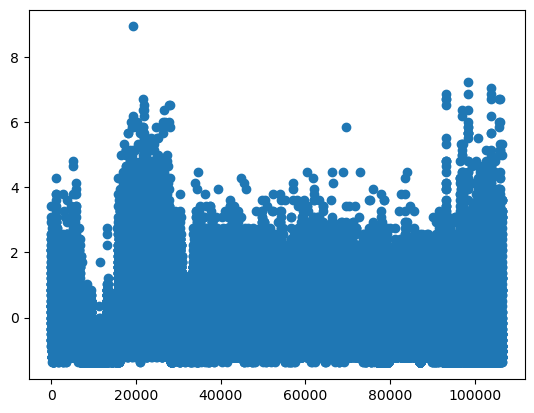

In [259]:
# plt.scatter(range(len(X_train[591:592,8,:].flatten())),X_train[591:592,8,:].flatten())
plt.scatter(range(len(X_train[:,:,8].flatten())),X_train[:,:,8].flatten())
# print(X_train[591:592,8,:].shape)
# print(len(X_train[:,8,:].flatten()))
# print("nz",np.count_nonzero(X_train[:,:,8].flatten() == (255-mean_value_lai)/std_val_lai))
# 660/106392
# X_train[:,:,8].flatten() == (255-mean_value_lai)/std_val_lai

In [260]:
# print(mean_value_ndvi, "is mean_value ndvi")
# print(mean_value_lai, "is mean_value lai")
# print(std_val_ndvi,'std ndvi')
# print(std_val_lai, 'std lai')


In [261]:
# std_val_ndvi

## Final Reshaping of data to shape/format: (samples, timesteps, features)

### HERE: Drop VCF as target

In [262]:
#DROP VCF as output?

#final reshaping for multihead model
# You can stack the y_train and y_test variables as 1-d arrays originally as follows:
y_train = np.dstack((y_train1, y_train2))#, y_train3))  # 3D numpy array (note chat wanted column_stack)
y_val = np.dstack((y_val1, y_val2))#, y_val3))
y_test = np.dstack((y_test1, y_test2))#, y_test3))

print(y_test1.shape)
print(y_test.shape)


(111, 98, 1)
(111, 98, 2)


Test (graph) viz of variables to ensure theyre still on same scale as each other after standardization process


(111, 98, 1)
(111, 132, 11)


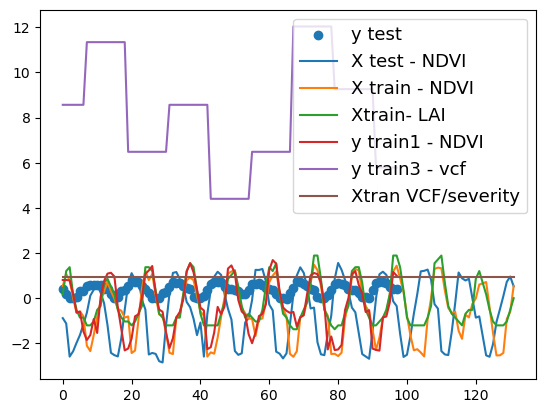

In [263]:
 
m_ind = 4
# plt.scatter(range(98),y_test1[m_ind,:,0], label="y test1") #range of NDVI is around 0 - 400
plt.scatter(range(98),y_test[m_ind,:,0], label="y test") #range of NDVI is around 0 - 400

print(y_test1.shape)
print(X_test.shape)
plt.plot(range(132),X_test[m_ind,:,7], label = "X test - NDVI") #plot NDVI
plt.plot(range(132),X_train[m_ind,:,7], label="X train - NDVI") #plot NDVI
plt.plot(range(132), X_train[m_ind,:,8], label="Xtrain- LAI")
plt.plot(range(98),y_train1[m_ind,:,0],label = "y train1 - NDVI") #plot NDVI
plt.plot(range(98),y_train3[m_ind,:,0],label = "y train3 - vcf") #plot lai
plt.plot(range(132), X_test[m_ind,:,9], label="Xtran VCF/severity")
plt.legend()


### Get Total Mean, Range, and StDev NDVI and LAI across train/test/val

In [264]:
#get final mean, min, and max of NDVI and LAI
#get all NDVI values 
print(X_train.shape)

#append all ndvi values to list
Xtrain_ndvi = X_train[:,:,7].flatten().tolist()
Xtest_ndvi = X_test[:,:,7].flatten().tolist()
Xval_ndvi = X_val[:,:,7].flatten().tolist()
y_train_ndvi = y_train[:,:,0].flatten().tolist()
y_test_ndvi = y_test[:,:,0].flatten().tolist()
y_val_ndvi = y_val[:,:,0].flatten().tolist()
#print(len(y_val_ndvi), 'is len of validation ndvi (should be 98*81)', 98*81)
#append all lists
all_ndvi = Xtrain_ndvi + Xtest_ndvi + Xval_ndvi + y_train_ndvi + y_test_ndvi + y_val_ndvi
#print(len(all_ndvi), "should be:",98*998 + 132*998)

print("MEAN NDVI (all input and output train/val/test samples):", np.mean(all_ndvi)) 
print("Range:", min(all_ndvi), "to:", max(all_ndvi))
print("Std", np.std(all_ndvi))

#NOTE: ndvi should theoretically be between 0 and 1, but the raw data ranges from 

#now get mean and range of LAI:

Xtrain_lai = X_train[:,:,8].flatten().tolist()
Xtest_lai = X_test[:,:,8].flatten().tolist()
Xval_lai = X_val[:,:,8].flatten().tolist()
y_train_lai = y_train[:,:,1].flatten().tolist()
y_test_lai = y_test[:,:,1].flatten().tolist()
y_val_lai = y_val[:,:,1].flatten().tolist()
#append all lists
all_lai = Xtrain_lai + Xtest_lai + Xval_lai + y_train_lai + y_test_lai + y_val_lai
#print(len(all_lai), "should be:",98*998 + 132*998)

print("\nMEAN LAI (all input and output train/val/test samples):", np.mean(all_lai))
print("Range:", min(all_lai), "to:", max(all_lai))
print("std", np.std(all_lai))

#get mask of extreme values for NDVI and LAI for all samples for all timesteps for y_test
#mask for NDVI (points > one standard deviation from mean)
mask_ndvi = np.logical_or(y_test[:,:,0] > np.mean(all_ndvi)+ np.std(all_ndvi), y_test[:,:,0] < np.mean(all_ndvi)- np.std(all_ndvi))
mask_lai = np.logical_or(y_test[:,:,1] > np.mean(all_lai)+ np.std(all_lai), y_test[:,:,1] < np.mean(all_lai)- np.std(all_lai))


# print(mask_ndvi.shape) #111,98

(806, 132, 11)
MEAN NDVI (all input and output train/val/test samples): -0.26232809379779204
Range: -3.4031023458357392 to: 2.6577921829015825
Std 1.0041200293261128

MEAN LAI (all input and output train/val/test samples): -0.16041419235035295
Range: -1.3798188153129285 to: 8.933512961428923
std 0.9488981802856713


### save geometry and event ID of test samples

In [265]:
os.getcwd()

'/Users/clairesimpson/Desktop/CU/LSTM_Project/Output_Data/Data_2024_06_06'

In [266]:
print(y_test.shape)
print(test_geom.shape) ## samples, 2nd dim = geom, eventids attributes
test_geom_df = pd.DataFrame(test_geom, columns = ['geometry', 'Event_ID'])
# #convert np array to geodataframe:
test_geom_gdf = gpd.GeoDataFrame(data = test_geom_df, geometry="geometry")
print(test_geom_gdf.head())
# #save

test_geom_gdf.to_file("TestSamples_EventID_Geom.shp")



(111, 98, 2)
(111, 2)
                      geometry               Event_ID
0  POINT (-107.56831 37.41804)  CO3741010757920121016
1  POINT (-107.60567 37.43420)  CO3741010757920121016
2  POINT (-107.58005 37.41719)  CO3741010757920121016
3  POINT (-107.59285 37.42570)  CO3741010757920121016
4  POINT (-107.59071 37.40697)  CO3741010757920121016


/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [267]:

#this point is in an aspen pixel: [-107.60566659593465,37.43420239378975]

# vallecito_pts = test_geom_gdf[test_geom_gdf['Event_ID'] == 'CO3741010757920121016']
# print(vallecito_pts)
# print("\n",vallecito_pts['geometry'][1])
# print(vallecito_pts['geometry'][1].x, vallecito_pts['geometry'][1].y)
# aspen_pt = vallecito_pts[vallecito_pts['geometry'].x == -107.60566668161259]#-107.60566659593465]# and vallecito_pts['geometry'].y == 37.43420239378975]
# print(aspen_pt, "aspen pt\n")


#now get index in test_geom where this point is located:
aspen_index = test_geom_gdf[test_geom_gdf['geometry'].x == -107.60566668161259][test_geom_gdf['geometry'].y == 37.4342031772499][test_geom_gdf['Event_ID'] == 'CO3741010757920121016'].index[0]
print("\n\n",aspen_index, "is aspen index")
print(test_geom[1])
print('\n\n', test_geom_gdf.iloc[aspen_index])
x_test_df_storeIDs[1]

# print(len(aspen_index))




 1 is aspen index
[<POINT (-108 37.4)> 'CO3741010757920121016']


 geometry    POINT (-107.6056666816126 37.4342031772499)
Event_ID                          CO3741010757920121016
Name: 1, dtype: object


/Users/clairesimpson/anaconda3/envs/deep_learning/lib/python3.10/site-packages/geopandas/geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


array(['CO3741010757920121016'], dtype=object)

In [268]:
## get ponderosa pine (evergreen) pt:
print(test_geom_gdf.iloc[81])
h12_pts = test_geom_gdf[test_geom_gdf['Event_ID'] == 'NM3696310515520100523']
#[-105.14589714092335,36.97220831094537]
#(-105.145897270002 36.97220900977032)
print(test_geom_gdf['geometry'][81].x, test_geom_gdf['geometry'][81].y)
# print(test_geom_gdf['geometry'][81].x - -105.14589714092335,
#        test_geom_gdf['geometry'][81].y - 36.97220831094537)


pondy_index = test_geom_gdf[test_geom_gdf['geometry'].x == -105.14589727000201][test_geom_gdf['geometry'].y == 36.97220900977032][test_geom_gdf['Event_ID'] == 'NM3696310515520100523'].index[0]
print("\n\n",pondy_index,"is pondy index\n\n")

print("should be true:",x_test_df_storeIDs[81] == 'NM3696310515520100523')

# count_3 = 0
# for row in test_geom_gdf.iterrows():
#     # print("ROW\n\n:",row[1])
#     if abs(row[1].geometry.x +105.14589714092335) <0.000001:
#         print(row[1].geometry.x + 105.14589714092335)
        # count_3+=1


# print(test_geom_gdf[abs(test_geom_gdf['geometry'].x +105.14589714092335) < 0.000001 ]) #should be just 1 of these
# print(h12_pts)
# pondy_pt = 

geometry    POINT (-105.145897270002 36.97220900977032)
Event_ID                          NM3696310515520100523
Name: 81, dtype: object
-105.14589727000201 36.97220900977032


 81 is pondy index


should be true: [ True]


In [269]:
np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)
np.save( "X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)
np.save("y_test.npy", y_test)
np.save("y_train1.npy", y_train1)
np.save("y_train2.npy", y_train2)
np.save("y_test1.npy", y_test1)
np.save("y_test2.npy", y_test2)
np.save("y_val1.npy", y_val1)
np.save("y_val2.npy", y_val2) #note: saving stdardized data so will need ot unstd. to get back to real val range
